In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
os.makedirs('/content/drive/My Drive/colab_data', exist_ok=True)
%cd /content/drive/My Drive/colab_data


/content/drive/My Drive/colab_data


In [ ]:
!git clone https://github.com/david-wb/gaze-estimation.git


Cloning into 'gaze-estimation'...
remote: Enumerating objects: 356, done.
remote: Counting objects: 100% (2/2), done.
remote: Total 356 (delta 1), reused 1 (delta 1), pack-reused 354
Receiving objects: 100% (356/356), 1.96 MiB | 4.84 MiB/s, done.
Resolving deltas: 100% (197/197), done.


In [3]:
%cd /content/drive/My Drive/colab_data/gaze-estimation


/content/drive/My Drive/colab_data/gaze-estimation


In [4]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create and change directory to colab_data
os.makedirs('/content/drive/My Drive/colab_data', exist_ok=True)
%cd /content/drive/My Drive/colab_data

# Clone the repository
!git clone https://github.com/david-wb/gaze-estimation.git

# Navigate to the cloned repository
%cd gaze-estimation


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/colab_data
fatal: destination path 'gaze-estimation' already exists and is not an empty directory.
/content/drive/My Drive/colab_data/gaze-estimation


In [ ]:
!pip install dlib imutils


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/colab_data/gaze-estimation
cuda:0


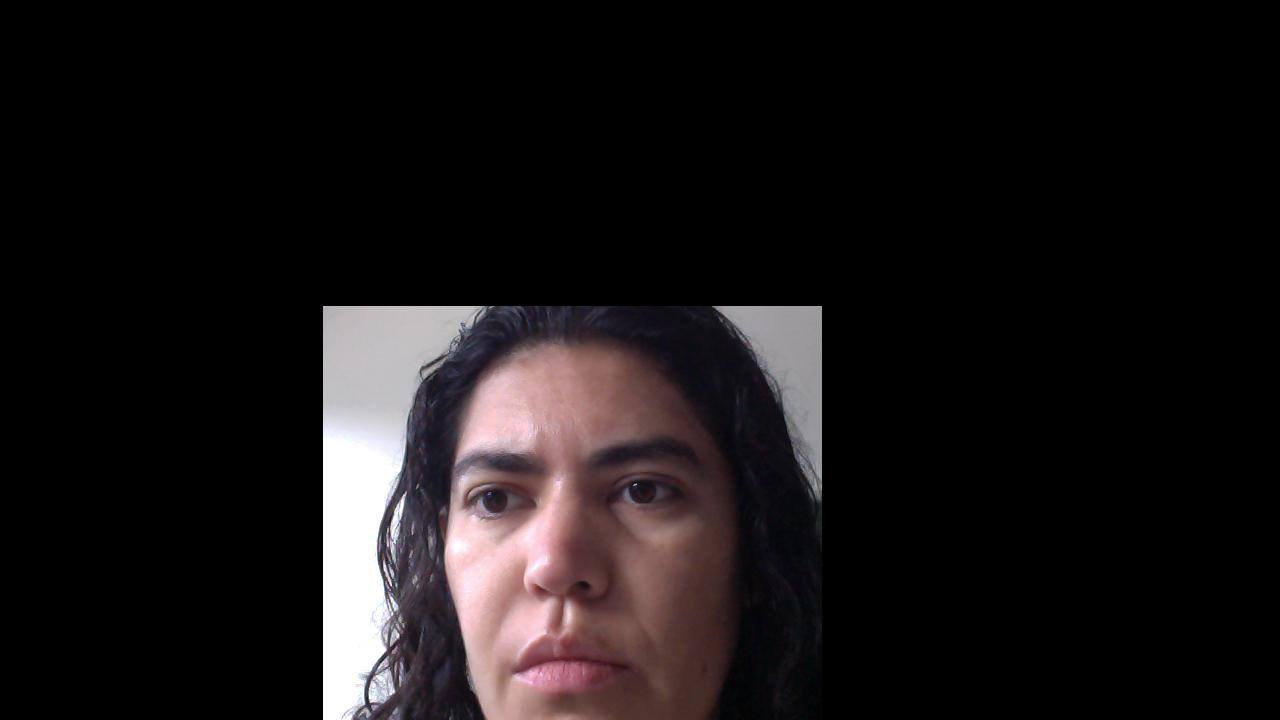

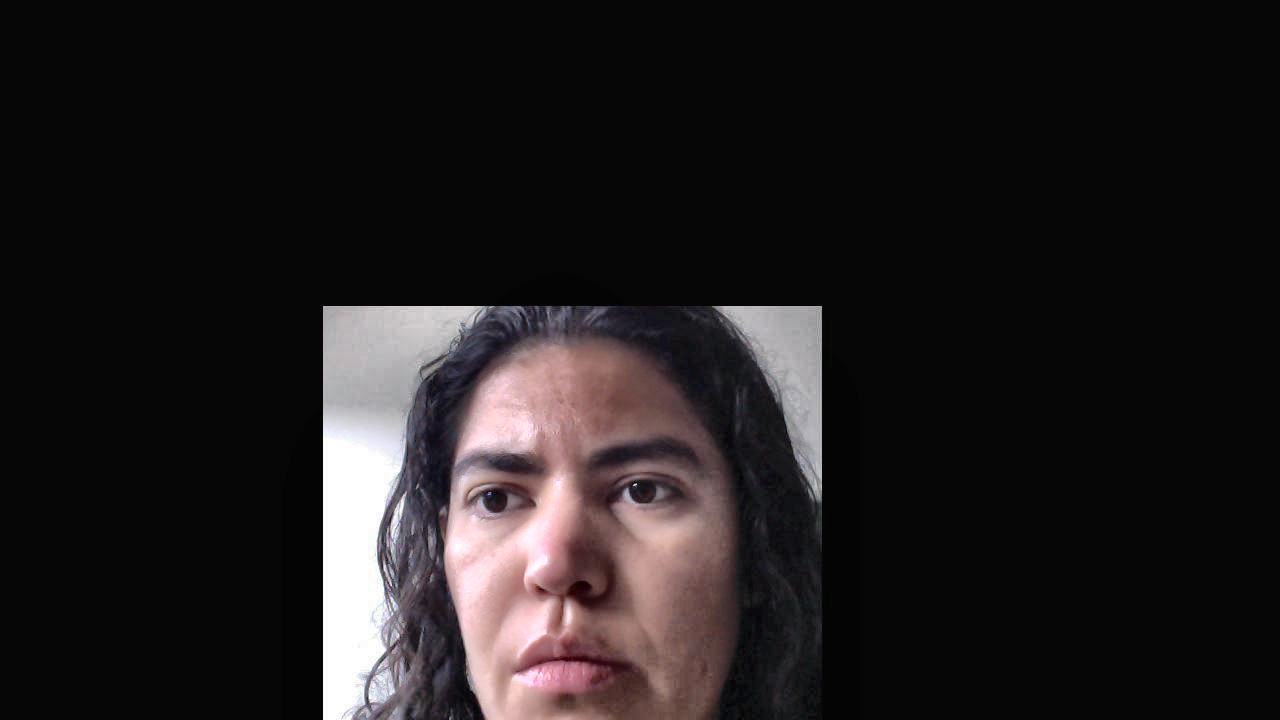

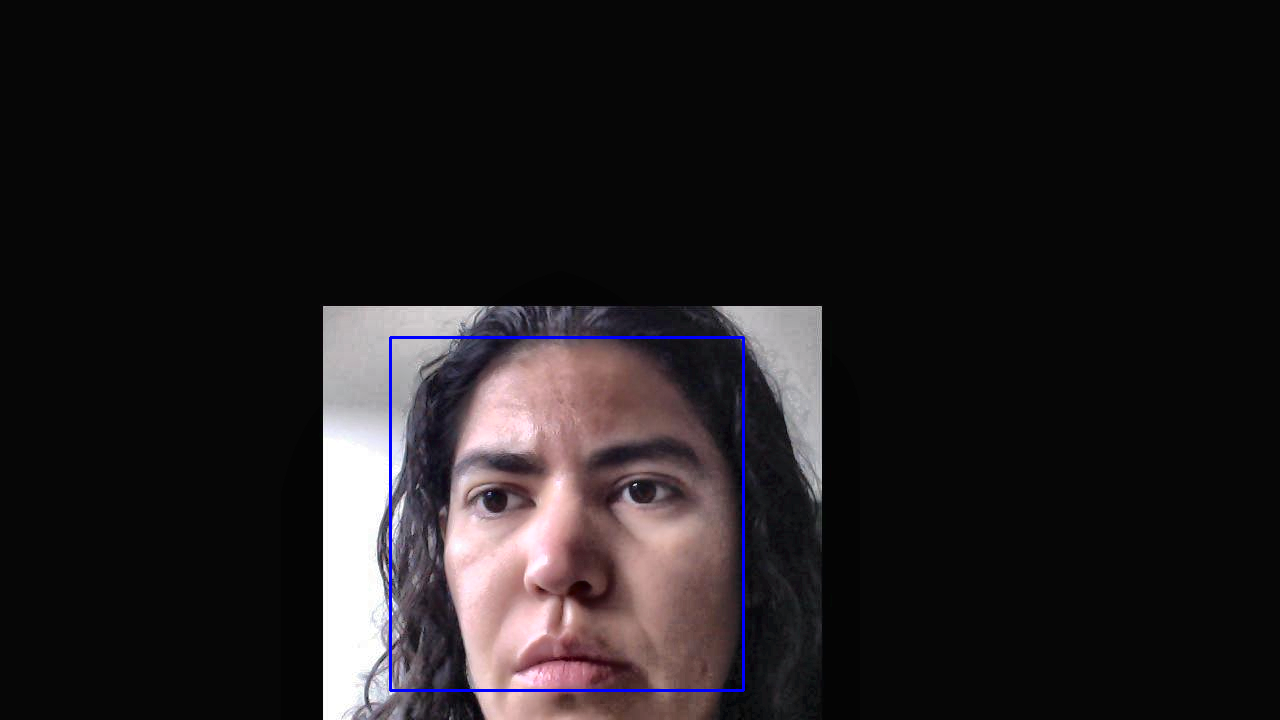

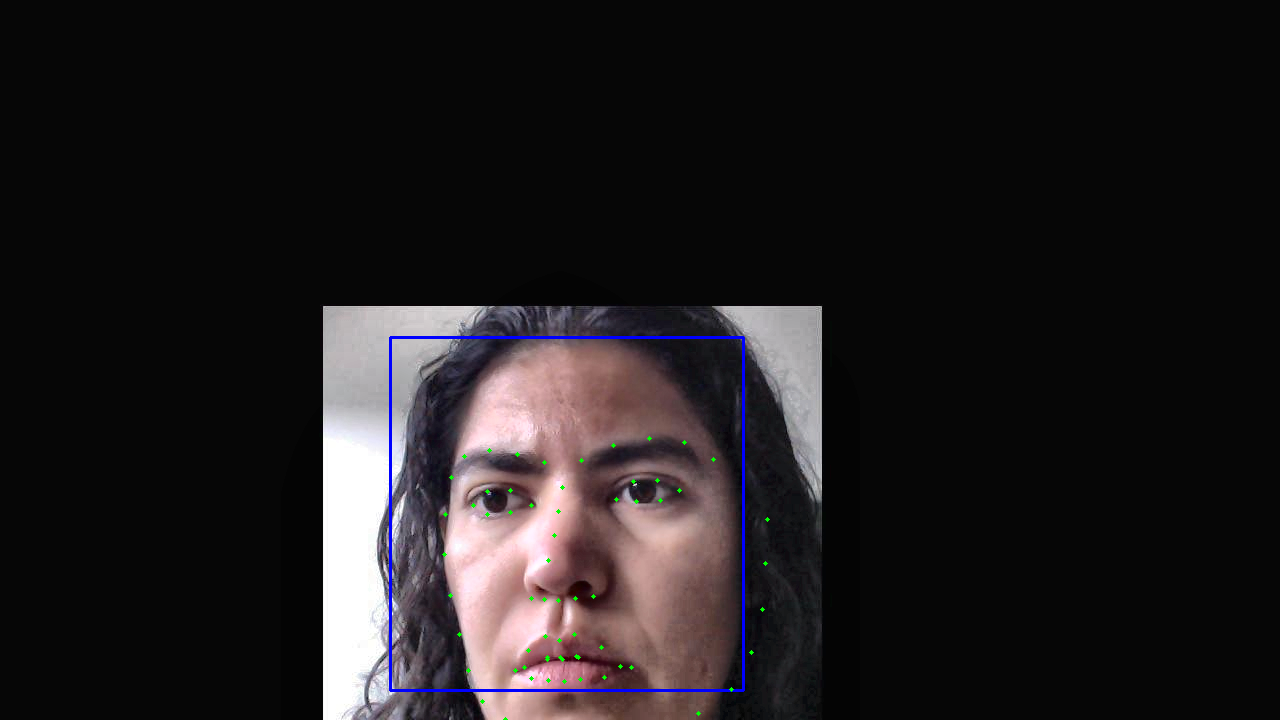

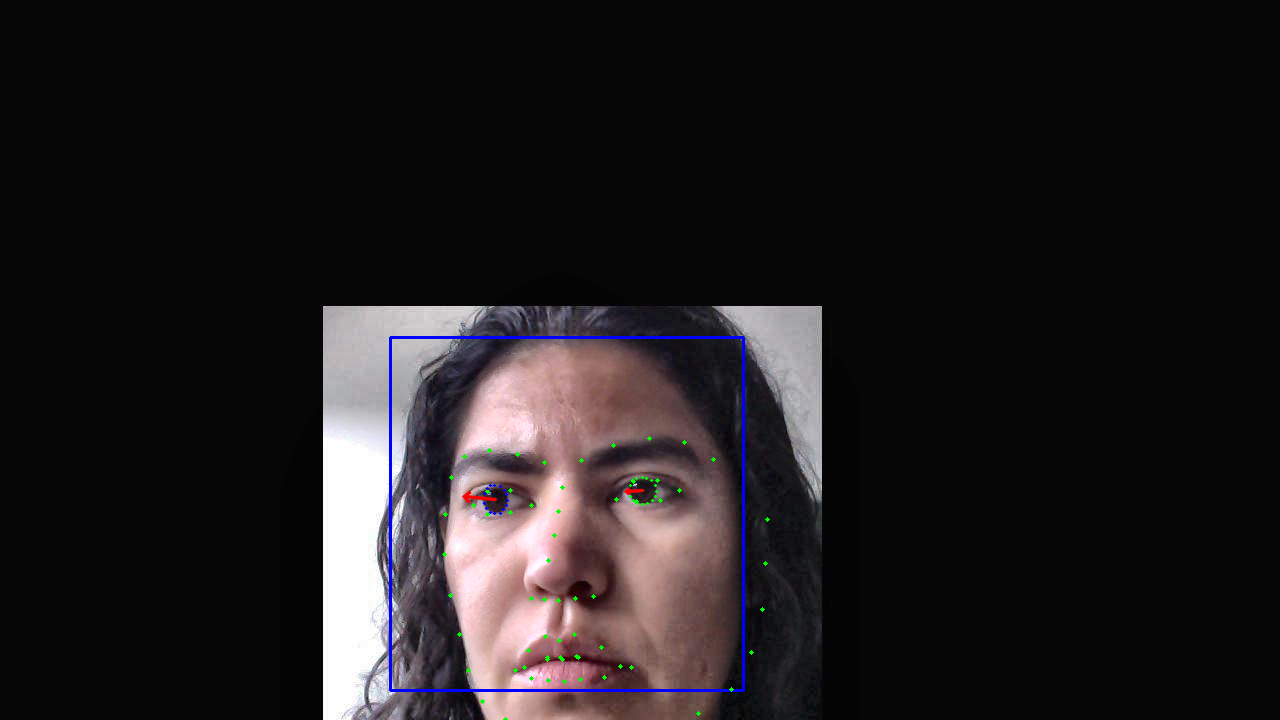

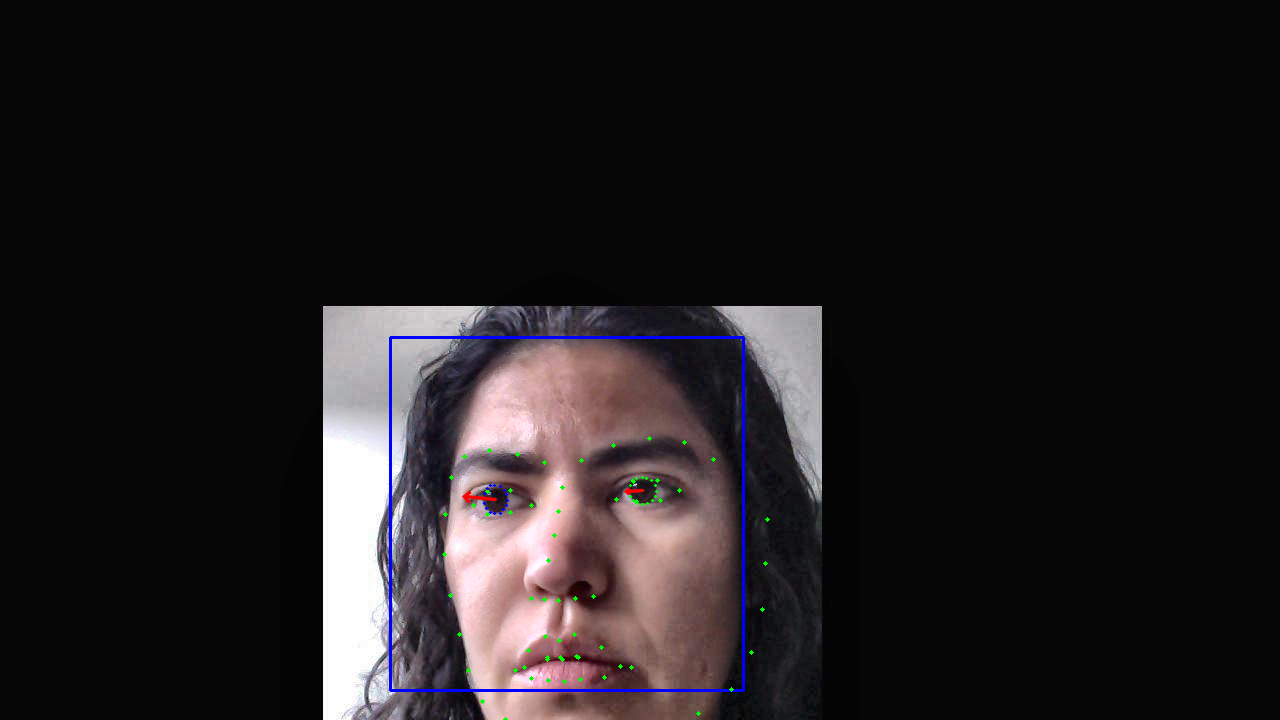

In [ ]:
from google.colab import drive
import os
import torch
from typing import List
import numpy as np
import cv2
import dlib
from imutils import face_utils
from models.eyenet import EyeNet
from util.eye_prediction import EyePrediction
from util.eye_sample import EyeSample
import util.gaze
from google.colab.patches import cv2_imshow

# Mount Google Drive
drive.mount('/content/drive')

# Change directory to the cloned repository
%cd /content/drive/My Drive/colab_data/gaze-estimation

# Install dependencies
!pip install dlib imutils

torch.backends.cudnn.enabled = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Load the landmark detector
landmarks_detector = dlib.shape_predictor('/content/drive/MyDrive/colab_data/gaze-estimation/shape_predictor_68_face_landmarks (1).dat')

# Verify the path to the MMOD face detector model
mmod_model_path = '/content/drive/MyDrive/colab_data/gaze-estimation/mmod_human_face_detector.dat'
if not os.path.isfile(mmod_model_path):
    raise FileNotFoundError(f"MMOD face detector model not found at {mmod_model_path}")

# Load the Dlib MMOD face detector
face_detector = dlib.cnn_face_detection_model_v1(mmod_model_path)

# Load the EyeNet model
checkpoint = torch.load('/content/drive/MyDrive/colab_data/gaze-estimation/checkpoint.pt', map_location=device)
nstack = checkpoint['nstack']
nfeatures = checkpoint['nfeatures']
nlandmarks = checkpoint['nlandmarks']
eyenet = EyeNet(nstack=nstack, nfeatures=nfeatures, nlandmarks=nlandmarks).to(device)
eyenet.load_state_dict(checkpoint['model_state_dict'])

def save_image(image, step):
    cv2.imwrite(f'/content/drive/MyDrive/colab_data/gaze-estimation/{step}.png', image)
    cv2_imshow(image)

def enhance_image(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return enhanced_img

def process_frame(frame_bgr, eye_preds_cache, visualize):
    if visualize:
        save_image(frame_bgr, 'original_image')

    orig_frame = frame_bgr.copy()
    enhanced_frame = enhance_image(orig_frame)
    if visualize:
        save_image(enhanced_frame, 'enhanced_image')

    gray_frame = cv2.cvtColor(enhanced_frame, cv2.COLOR_BGR2GRAY)

    # Use Dlib MMOD face detector
    faces = face_detector(gray_frame, 1)

    # Draw rectangles around detected faces
    for face in faces:
        x, y, w, h = (face.rect.left(), face.rect.top(), face.rect.width(), face.rect.height())
        cv2.rectangle(enhanced_frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

    if visualize:
        save_image(enhanced_frame, 'detected_faces')

    if len(faces) == 0:
        return enhanced_frame, eye_preds_cache

    next_face = faces[0].rect
    landmarks = detect_landmarks(next_face, gray_frame)

    if visualize:
        for (x, y) in landmarks:
            cv2.circle(enhanced_frame, (x, y), 2, (0, 255, 0), -1)
        save_image(enhanced_frame, 'detected_landmarks')

    if landmarks is not None:
        eye_samples = segment_eyes(gray_frame, landmarks)
        eye_preds_cache = run_eyenet(eye_samples)

        left_eyes = list(filter(lambda x: x.eye_sample.is_left, eye_preds_cache))
        right_eyes = list(filter(lambda x: not x.eye_sample.is_left, eye_preds_cache))

        for ep in left_eyes + right_eyes:
            if ep is not None:
                for (x, y) in ep.landmarks[16:33]:
                    color = (0, 255, 0)
                    if ep.eye_sample.is_left:
                        color = (255, 0, 0)
                    cv2.circle(enhanced_frame, (int(round(x)), int(round(y))), 1, color, -1, lineType=cv2.LINE_AA)

                gaze = ep.gaze.copy()
                if ep.eye_sample.is_left:
                    gaze[1] = -gaze[1]
                util.gaze.draw_gaze(enhanced_frame, ep.landmarks[-2], gaze, length=60.0, thickness=2)

    if visualize:
        save_image(enhanced_frame, 'gaze_estimation')
    return enhanced_frame, eye_preds_cache

def detect_landmarks(face, frame):
    rectangle = dlib.rectangle(face.left(), face.top(), face.right(), face.bottom())
    face_landmarks = landmarks_detector(frame, rectangle)
    return face_utils.shape_to_np(face_landmarks)

def segment_eyes(frame, landmarks, ow=160, oh=96):
    eyes = []
    for corner1, corner2, is_left in [(36, 39, True), (42, 45, False)]:
        x1, y1 = landmarks[corner1, :]
        x2, y2 = landmarks[corner2, :]
        eye_width = 1.5 * np.linalg.norm(landmarks[corner1, :] - landmarks[corner2, :])
        if eye_width == 0.0:
            return eyes

        cx, cy = 0.5 * (x1 + x2), 0.5 * (y1 + y2)
        translate_mat = np.asmatrix(np.eye(3))
        translate_mat[:2, 2] = [[-cx], [-cy]]
        inv_translate_mat = np.asmatrix(np.eye(3))
        inv_translate_mat[:2, 2] = -translate_mat[:2, 2]
        scale = ow / eye_width
        scale_mat = np.asmatrix(np.eye(3))
        scale_mat[0, 0] = scale_mat[1, 1] = scale
        inv_scale = 1.0 / scale
        inv_scale_mat = np.asmatrix(np.eye(3))
        inv_scale_mat[0, 0] = inv_scale_mat[1, 1] = inv_scale
        estimated_radius = 0.5 * eye_width * scale
        center_mat = np.asmatrix(np.eye(3))
        center_mat[:2, 2] = [[0.5 * ow], [0.5 * oh]]
        inv_center_mat = np.asmatrix(np.eye(3))
        inv_center_mat[:2, 2] = -center_mat[:2, 2]
        transform_mat = center_mat * scale_mat * translate_mat
        inv_transform_mat = (inv_translate_mat * inv_scale_mat * inv_center_mat)
        eye_image = cv2.warpAffine(frame, transform_mat[:2, :], (ow, oh))
        eye_image = cv2.equalizeHist(eye_image)

        if is_left:
            eye_image = np.fliplr(eye_image)
        eyes.append(EyeSample(orig_img=frame.copy(),
                              img=eye_image,
                              transform_inv=inv_transform_mat,
                              is_left=is_left,
                              estimated_radius=estimated_radius))
    return eyes

def run_eyenet(eyes: List[EyeSample], ow=160, oh=96) -> List[EyePrediction]:
    result = []
    for eye in eyes:
        with torch.no_grad():
            x = torch.tensor([eye.img], dtype=torch.float32).to(device)
            _, landmarks, gaze = eyenet.forward(x)
            landmarks = np.asarray(landmarks.cpu().numpy()[0])
            gaze = np.asarray(gaze.cpu().numpy()[0])
            assert gaze.shape == (2,)
            assert landmarks.shape == (34, 2)

            landmarks = landmarks * np.array([oh / 48, ow / 80])

            temp = np.zeros((34, 3))
            if eye.is_left:
                temp[:, 0] = ow - landmarks[:, 1]
            else:
                temp[:, 0] = landmarks[:, 1]
            temp[:, 1] = landmarks[:, 0]
            temp[:, 2] = 1.0
            landmarks = temp
            assert landmarks.shape == (34, 3)
            landmarks = np.asarray(np.matmul(landmarks, eye.transform_inv.T))[:, :2]
            assert landmarks.shape == (34, 2)
            result.append(EyePrediction(eye_sample=eye, landmarks=landmarks, gaze=gaze))
    return result

# Path to the input image
input_image_path = '/content/drive/MyDrive/colab_data/gaze-estimation/left.jpg'
# Path to save the output image
output_image_path = '/content/drive/MyDrive/colab_data/gaze-estimation/output_image.jpg'

# Read the image
image = cv2.imread(input_image_path)
if image is None:
    raise FileNotFoundError(f"Input image not found at {input_image_path}")

# Process the image
visualize = True
eye_preds_cache = None
processed_image, eye_preds_cache = process_frame(image, eye_preds_cache, visualize)

# Save the processed image
cv2.imwrite(output_image_path, processed_image)
cv2_imshow(processed_image)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/colab_data/gaze-estimation
cuda:0


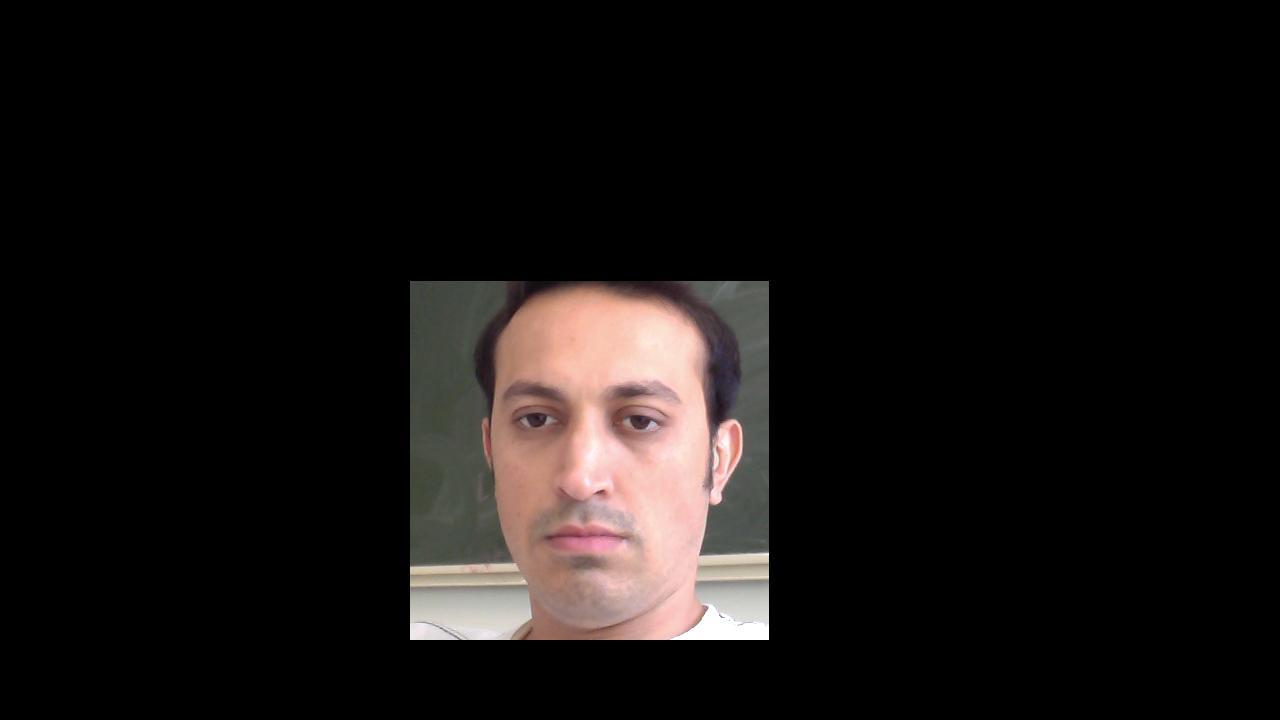

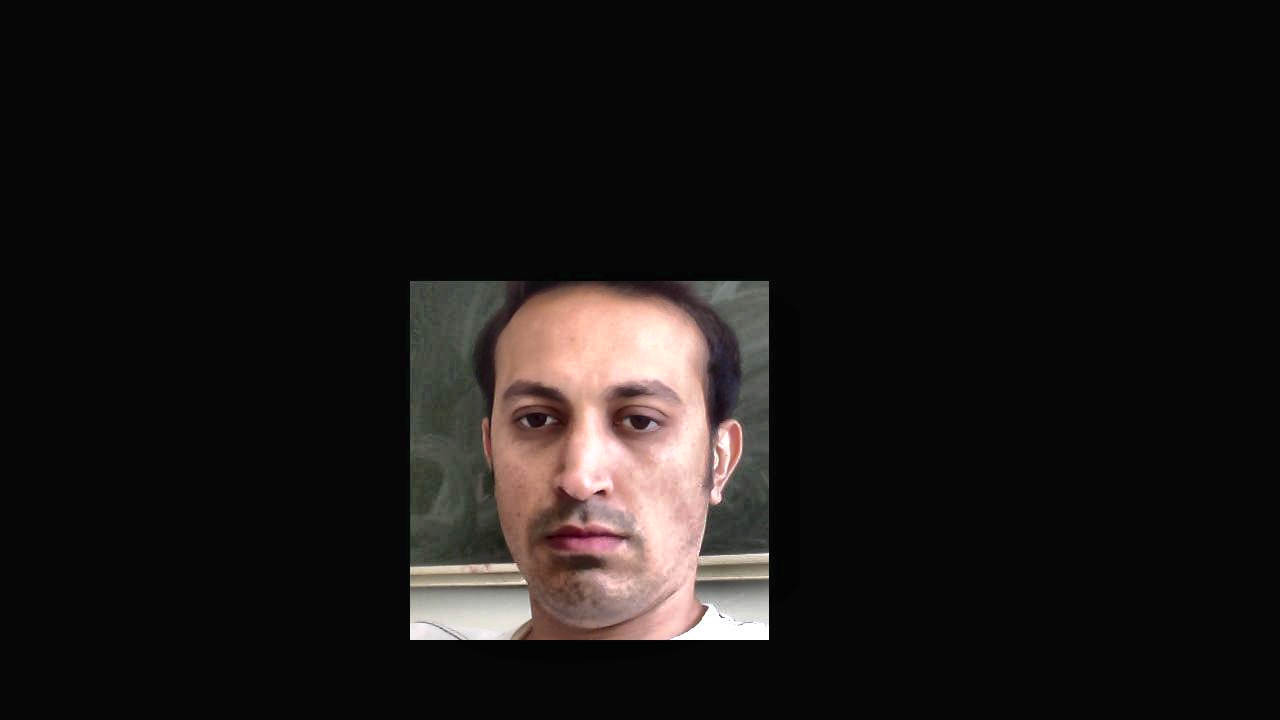

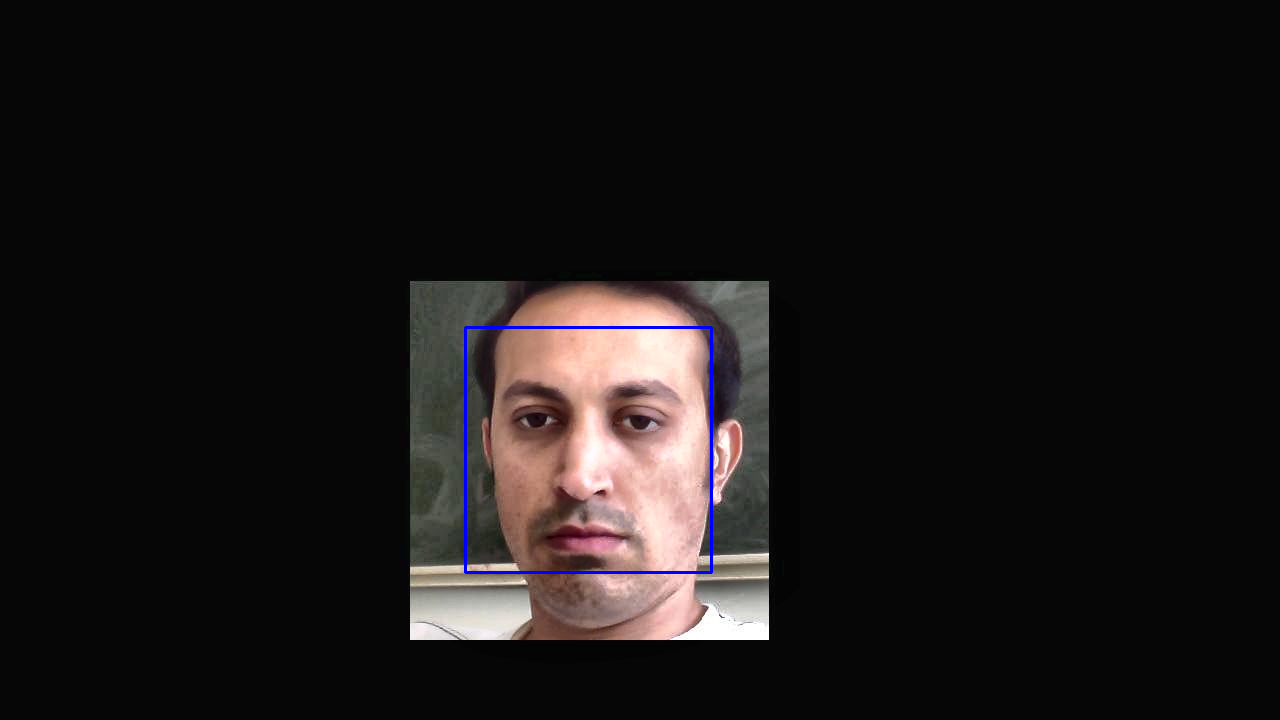

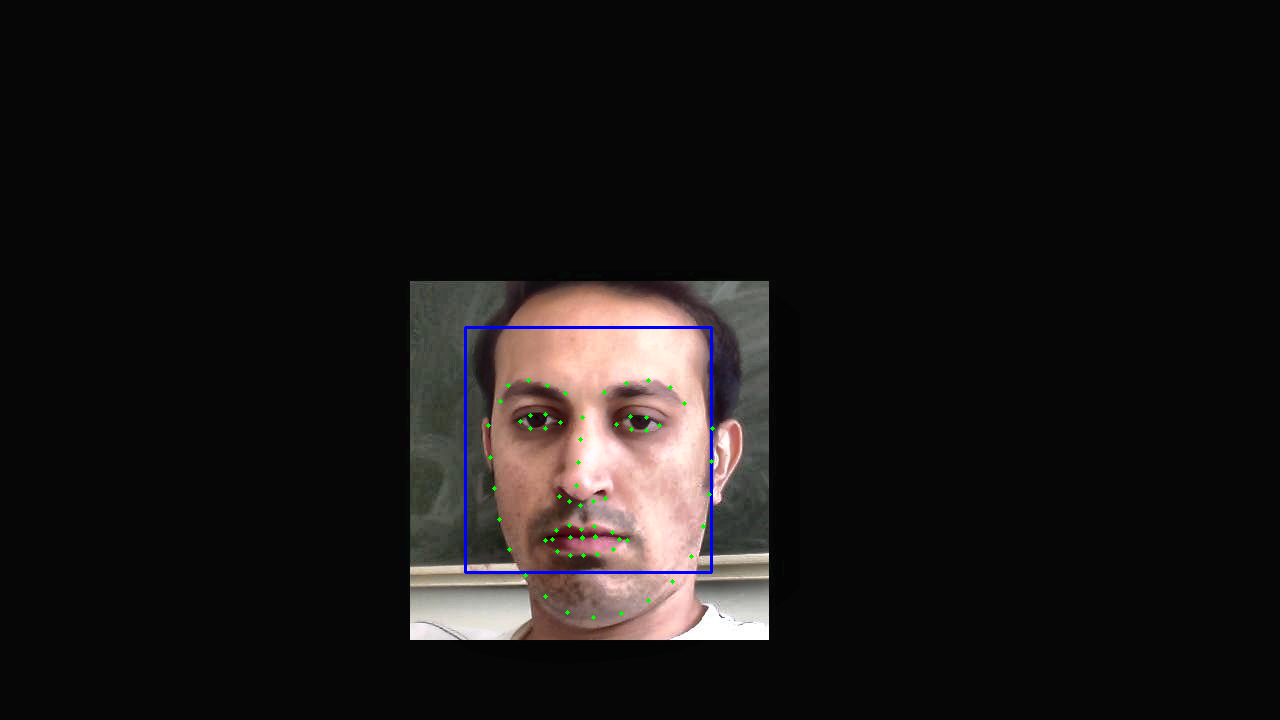

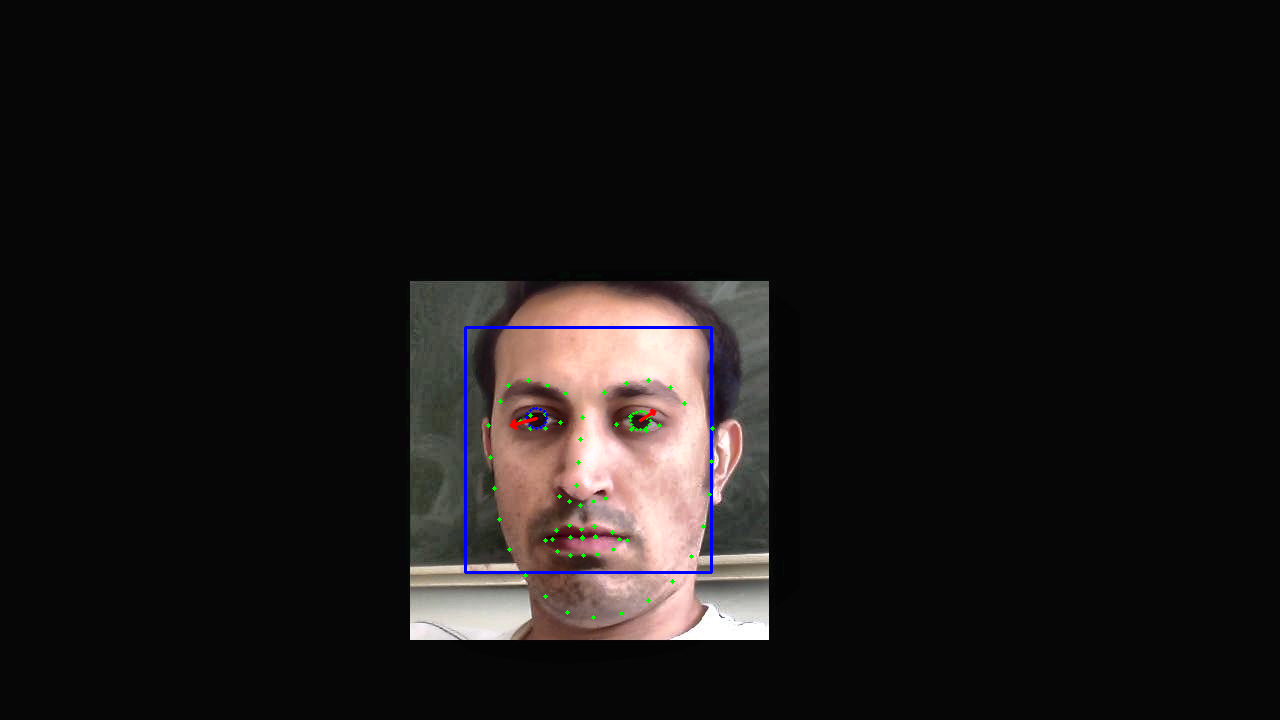

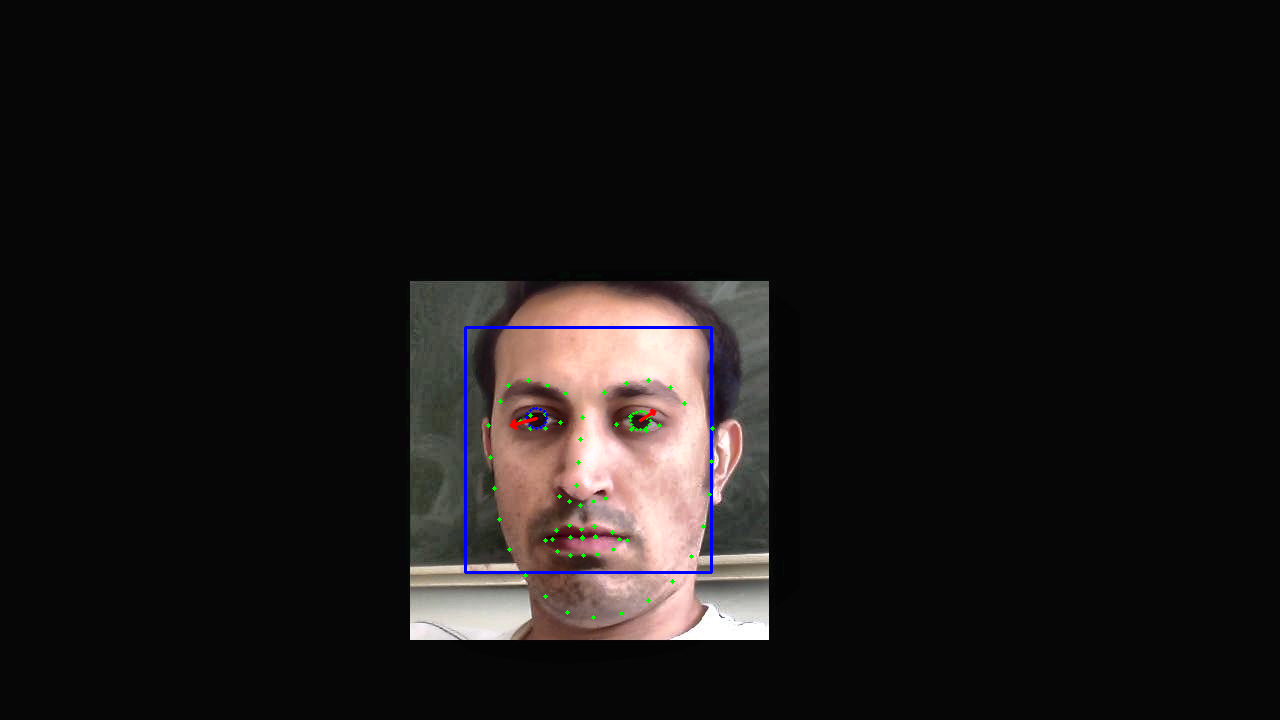

Left eye - Pitch: -105.00°, Yaw: -173.48°
Right eye - Pitch: 60.44°, Yaw: 172.19°


In [ ]:
from google.colab import drive
import os
import torch
from typing import List
import numpy as np
import cv2
import dlib
from imutils import face_utils
from models.eyenet import EyeNet
from util.eye_prediction import EyePrediction
from util.eye_sample import EyeSample
import util.gaze
from google.colab.patches import cv2_imshow
import math
from scipy.spatial.transform import Rotation as R

# Mount Google Drive
drive.mount('/content/drive')

# Change directory to the cloned repository
%cd /content/drive/My Drive/colab_data/gaze-estimation

# Install dependencies
!pip install dlib imutils

torch.backends.cudnn.enabled = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Load the landmark detector
landmarks_detector = dlib.shape_predictor('/content/drive/MyDrive/colab_data/gaze-estimation/shape_predictor_68_face_landmarks (1).dat')

# Verify the path to the MMOD face detector model
mmod_model_path = '/content/drive/MyDrive/colab_data/gaze-estimation/mmod_human_face_detector.dat'
if not os.path.isfile(mmod_model_path):
    raise FileNotFoundError(f"MMOD face detector model not found at {mmod_model_path}")

# Load the Dlib MMOD face detector
face_detector = dlib.cnn_face_detection_model_v1(mmod_model_path)

# Load the EyeNet model
checkpoint = torch.load('/content/drive/MyDrive/colab_data/gaze-estimation/checkpoint.pt', map_location=device)
nstack = checkpoint['nstack']
nfeatures = checkpoint['nfeatures']
nlandmarks = checkpoint['nlandmarks']
eyenet = EyeNet(nstack=nstack, nfeatures=nfeatures, nlandmarks=nlandmarks).to(device)
eyenet.load_state_dict(checkpoint['model_state_dict'])

def save_image(image, step):
    cv2.imwrite(f'/content/drive/MyDrive/colab_data/gaze-estimation/{step}.png', image)
    cv2_imshow(image)

def enhance_image(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return enhanced_img

def process_frame(frame_bgr, eye_preds_cache, visualize):
    if visualize:
        save_image(frame_bgr, 'original_image')

    orig_frame = frame_bgr.copy()
    enhanced_frame = enhance_image(orig_frame)

    if visualize:
        save_image(enhanced_frame, 'enhanced_image')

    gray_frame = cv2.cvtColor(enhanced_frame, cv2.COLOR_BGR2GRAY)

    # Use Dlib MMOD face detector
    faces = face_detector(gray_frame, 1)

    # Draw rectangles around detected faces
    for face in faces:
        x, y, w, h = (face.rect.left(), face.rect.top(), face.rect.width(), face.rect.height())
        cv2.rectangle(enhanced_frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

    if visualize:
        save_image(enhanced_frame, 'detected_faces')

    if len(faces) == 0:
        return enhanced_frame, eye_preds_cache, []

    next_face = faces[0].rect
    landmarks = detect_landmarks(next_face, gray_frame)

    if visualize:
        for (x, y) in landmarks:
            cv2.circle(enhanced_frame, (x, y), 2, (0, 255, 0), -1)
        save_image(enhanced_frame, 'detected_landmarks')

    gaze_angles = []

    if landmarks is not None:
        eye_samples = segment_eyes(gray_frame, landmarks)
        eye_preds_cache = run_eyenet(eye_samples)

        left_eyes = list(filter(lambda x: x.eye_sample.is_left, eye_preds_cache))
        right_eyes = list(filter(lambda x: not x.eye_sample.is_left, eye_preds_cache))

        for ep in left_eyes + right_eyes:
            if ep is not None:
                for (x, y) in ep.landmarks[16:33]:
                    color = (0, 255, 0)
                    if ep.eye_sample.is_left:
                        color = (255, 0, 0)
                    cv2.circle(enhanced_frame, (int(round(x)), int(round(y))), 1, color, -1, lineType=cv2.LINE_AA)

                gaze = ep.gaze.copy()
                if ep.eye_sample.is_left:
                    gaze[1] = -gaze[1]

                # Calculate gaze angles
                pitch = math.atan2(-gaze[1], -gaze[0])
                yaw = math.atan2(-gaze[0], -1.0)

                pitch_deg = math.degrees(pitch)
                yaw_deg = math.degrees(yaw)

                gaze_angles.append({
                    'eye': 'left' if ep.eye_sample.is_left else 'right',
                    'pitch': pitch_deg,
                    'yaw': yaw_deg
                })

                util.gaze.draw_gaze(enhanced_frame, ep.landmarks[-2], gaze, length=60.0, thickness=2)

    if visualize:
        save_image(enhanced_frame, 'gaze_estimation')

    return enhanced_frame, eye_preds_cache, gaze_angles

def detect_landmarks(face, frame):
    rectangle = dlib.rectangle(face.left(), face.top(), face.right(), face.bottom())
    face_landmarks = landmarks_detector(frame, rectangle)
    return face_utils.shape_to_np(face_landmarks)

def preprocess_unityeyes_image(img, ow=160, oh=96):
    ih, iw = img.shape[:2]
    ih_2, iw_2 = ih / 2.0, iw / 2.0

    heatmap_w = int(ow / 2)
    heatmap_h = int(oh / 2)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    def process_coords(coords_list):
        coords = [eval(l) for l in coords_list]
        return np.array([(x, ih - y, z) for (x, y, z) in coords])

    interior_landmarks = process_coords(json_data['interior_margin_2d'])
    caruncle_landmarks = process_coords(json_data['caruncle_2d'])
    iris_landmarks = process_coords(json_data['iris_2d'])

    left_corner = np.mean(caruncle_landmarks[:, :2], axis=0)
    right_corner = interior_landmarks[8, :2]
    eye_width = 1.5 * abs(left_corner[0] - right_corner[0])
    eye_middle = np.mean([np.amin(interior_landmarks[:, :2], axis=0),
                          np.amax(interior_landmarks[:, :2], axis=0)], axis=0)

    # Normalize to eye width
    scale = ow / eye_width

    translate = np.asmatrix(np.eye(3))
    translate[0, 2] = -eye_middle[0] * scale
    translate[1, 2] = -eye_middle[1] * scale

    rand_x = np.random.uniform(low=-10, high=10)
    rand_y = np.random.uniform(low=-10, high=10)
    recenter = np.asmatrix(np.eye(3))
    recenter[0, 2] = ow / 2 + rand_x
    recenter[1, 2] = oh / 2 + rand_y

    scale_mat = np.asmatrix(np.eye(3))
    scale_mat[0, 0] = scale
    scale_mat[1, 1] = scale

    angle = 0  # np.random.normal(0, 1) * 20 * np.pi / 180
    rotation = R.from_rotvec([0, 0, angle]).as_matrix()

    transform = recenter * rotation * translate * scale_mat
    transform_inv = np.linalg.inv(transform)

    # Apply transforms
    eye = cv2.warpAffine(img, transform[:2], (ow, oh))

    rand_blur = np.random.uniform(low=0, high=20)
    eye = cv2.GaussianBlur(eye, (5, 5), rand_blur)

    # Normalize eye image
    eye = cv2.equalizeHist(eye)
    eye = eye.astype(np.float32)
    eye = eye / 255.0

    return eye, transform, transform_inv

def segment_eyes(frame, landmarks, ow=160, oh=96):
    eyes = []
    for corner1, corner2, is_left in [(36, 39, True), (42, 45, False)]:
        x1, y1 = landmarks[corner1, :]
        x2, y2 = landmarks[corner2, :]
        eye_width = 1.5 * np.linalg.norm(landmarks[corner1, :] - landmarks[corner2, :])
        if eye_width == 0.0:
            continue
        cx, cy = 0.5 * (x1 + x2), 0.5 * (y1 + y2)
        translate_mat = np.asmatrix(np.eye(3))
        translate_mat[:2, 2] = [[-cx], [-cy]]
        scale = ow / eye_width
        scale_mat = np.asmatrix(np.eye(3))
        scale_mat[0, 0] = scale_mat[1, 1] = scale
        center_mat = np.asmatrix(np.eye(3))
        center_mat[:2, 2] = [[0.5 * ow], [0.5 * oh]]
        transform_mat = center_mat * scale_mat * translate_mat
        transform_inv = np.linalg.inv(transform_mat)

        eye_image = cv2.warpAffine(frame, transform_mat[:2], (ow, oh))
        eye_image = cv2.equalizeHist(eye_image)
        if is_left:
            eye_image = np.fliplr(eye_image)

        eyes.append(EyeSample(orig_img=frame.copy(),
                              img=eye_image,
                              transform_inv=transform_inv,
                              is_left=is_left,
                              estimated_radius=0.5 * eye_width * scale))
    return eyes

def run_eyenet(eyes: List[EyeSample], ow=160, oh=96) -> List[EyePrediction]:
    result = []
    for eye in eyes:
        with torch.no_grad():
            x = torch.tensor([eye.img], dtype=torch.float32).to(device)
            _, landmarks, gaze = eyenet.forward(x)
            landmarks = np.asarray(landmarks.cpu().numpy()[0])
            gaze = np.asarray(gaze.cpu().numpy()[0])
            assert gaze.shape == (2,)
            assert landmarks.shape == (34, 2)
            landmarks = landmarks * np.array([oh / 48, ow / 80])
            temp = np.zeros((34, 3))
            if eye.is_left:
                temp[:, 0] = ow - landmarks[:, 1]
            else:
                temp[:, 0] = landmarks[:, 1]
            temp[:, 1] = landmarks[:, 0]
            temp[:, 2] = 1.0
            landmarks = temp
            assert landmarks.shape == (34, 3)
            landmarks = np.asarray(np.matmul(landmarks, eye.transform_inv.T))[:, :2]
            assert landmarks.shape == (34, 2)
            result.append(EyePrediction(eye_sample=eye, landmarks=landmarks, gaze=gaze))
    return result

# Path to the input image
input_image_path = '/content/drive/MyDrive/colab_data/gaze-estimation/0049.jpg'

# Path to save the output image
output_image_path = '/content/drive/MyDrive/colab_data/gaze-estimation/output_image.jpg'

# Read the image
image = cv2.imread(input_image_path)
if image is None:
    raise FileNotFoundError(f"Input image not found at {input_image_path}")

# Process the image
visualize = True
eye_preds_cache = None
processed_image, eye_preds_cache, gaze_angles = process_frame(image, eye_preds_cache, visualize)

# Save the processed image
cv2.imwrite(output_image_path, processed_image)
cv2_imshow(processed_image)

# Print gaze angles
for angle in gaze_angles:
    print(f"{angle['eye'].capitalize()} eye - Pitch: {angle['pitch']:.2f}°, Yaw: {angle['yaw']:.2f}°")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/colab_data/gaze-estimation
cuda:0


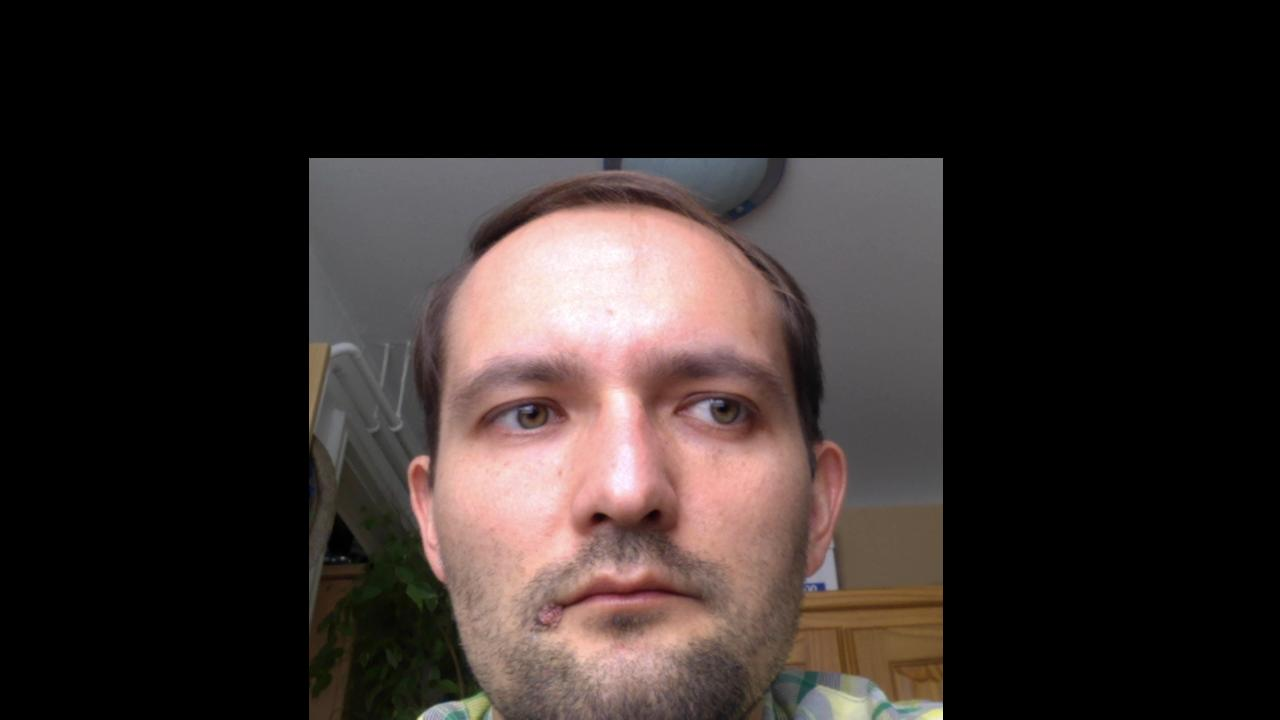

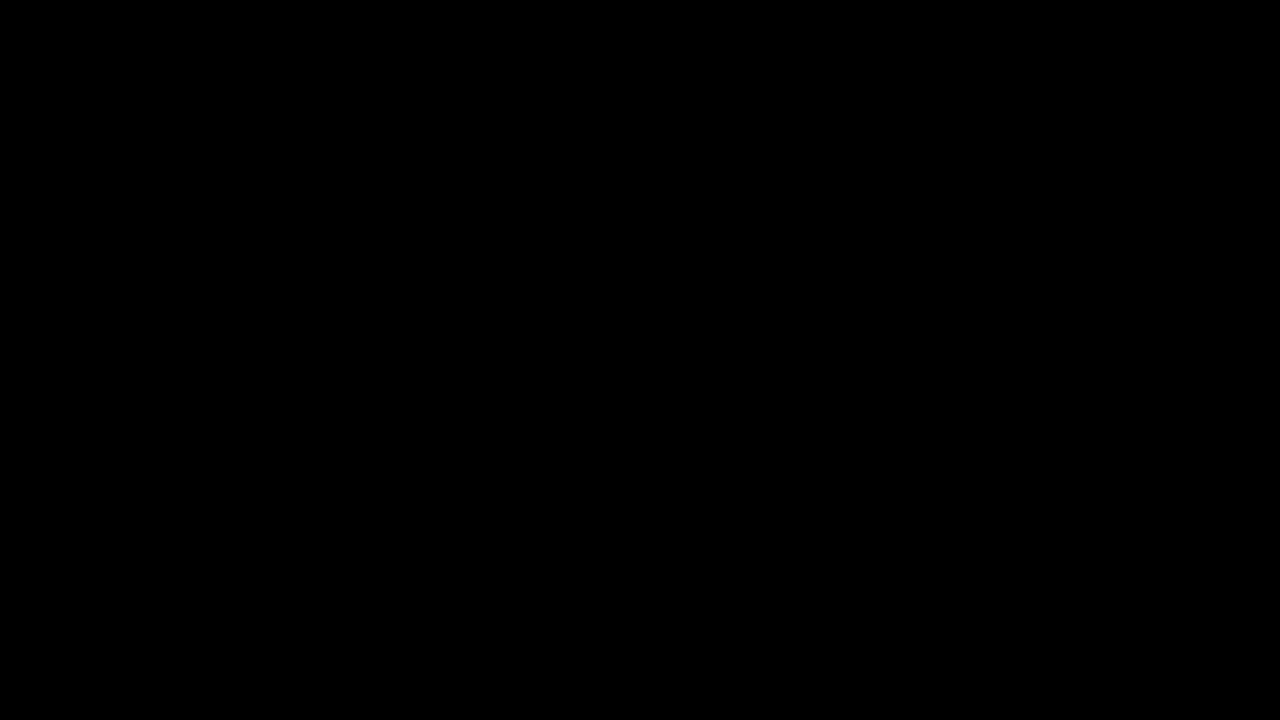

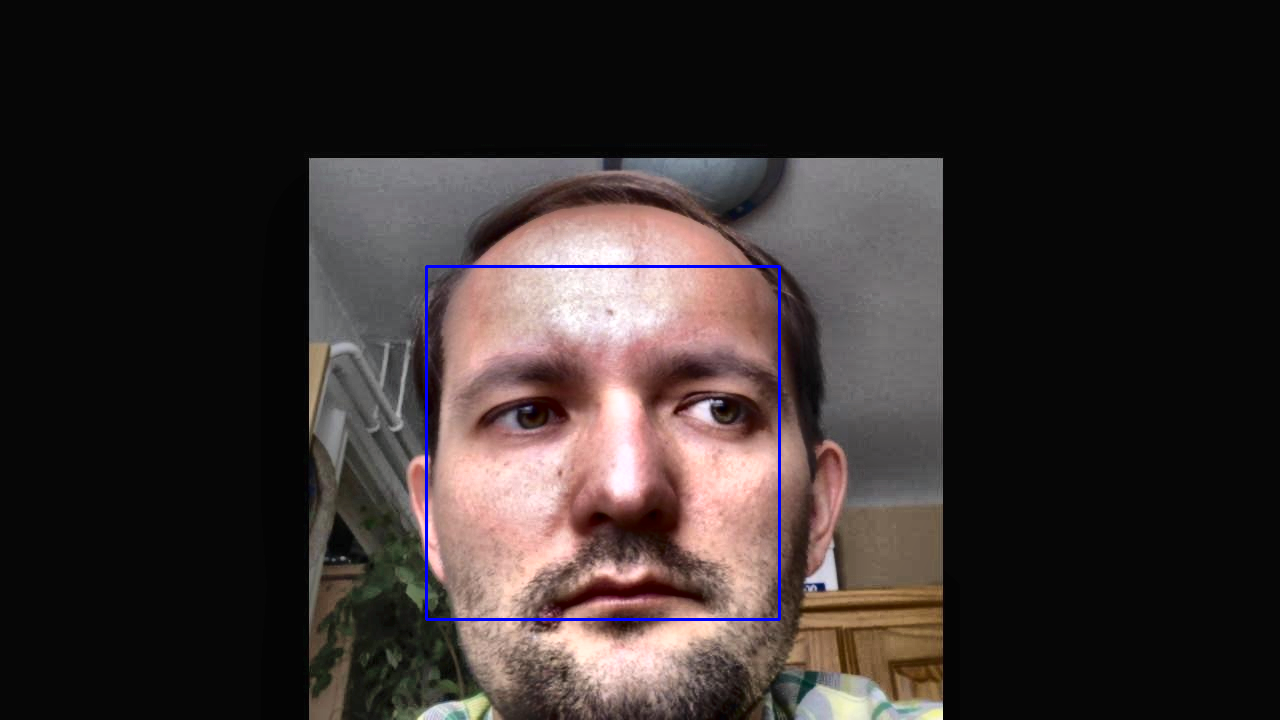

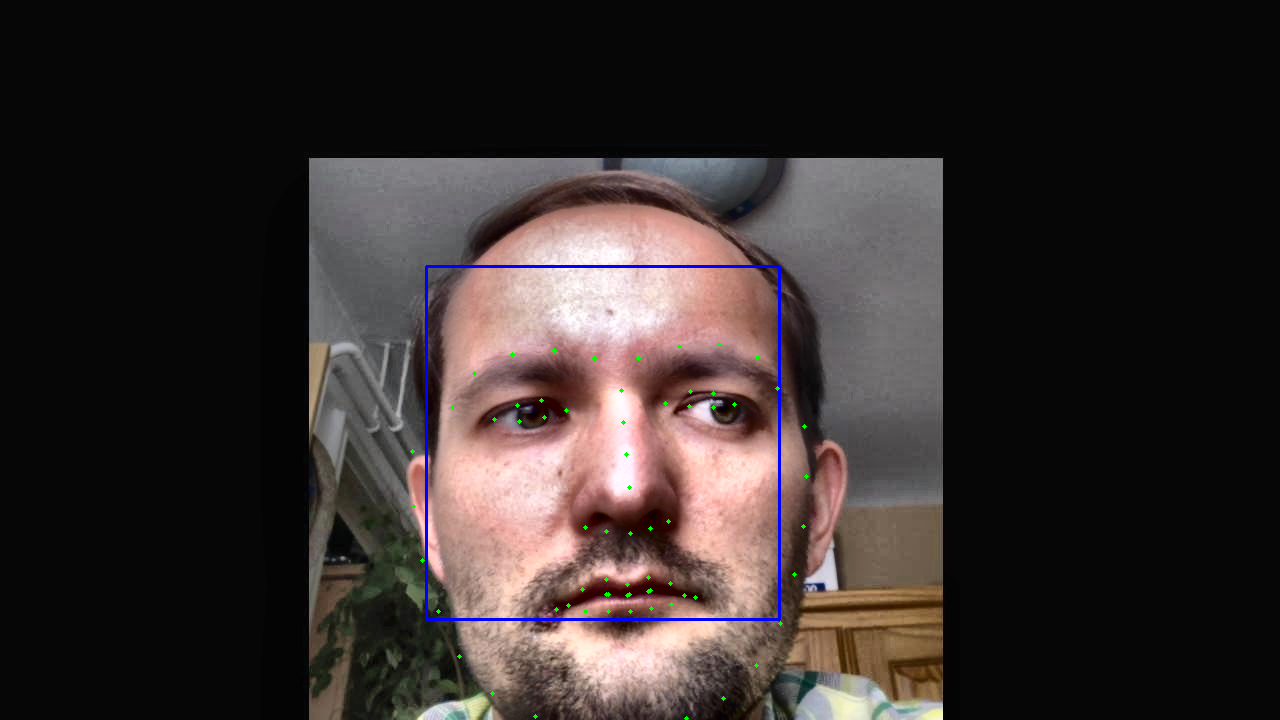

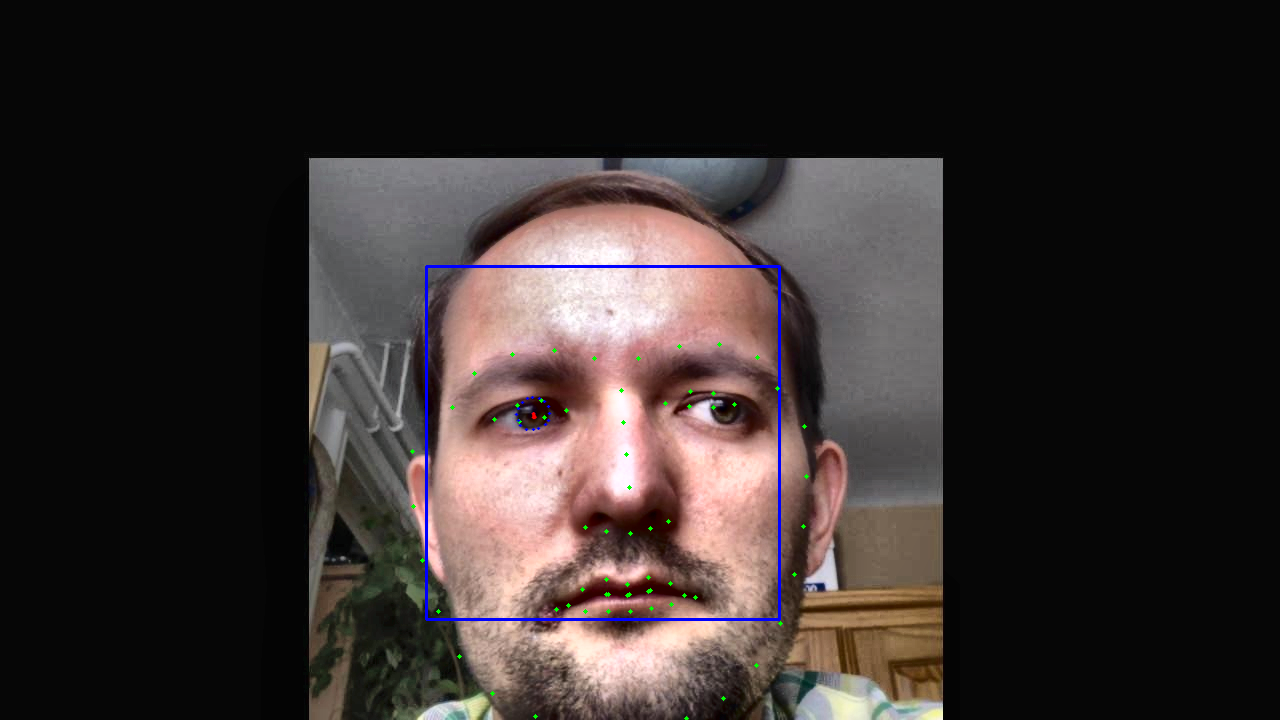

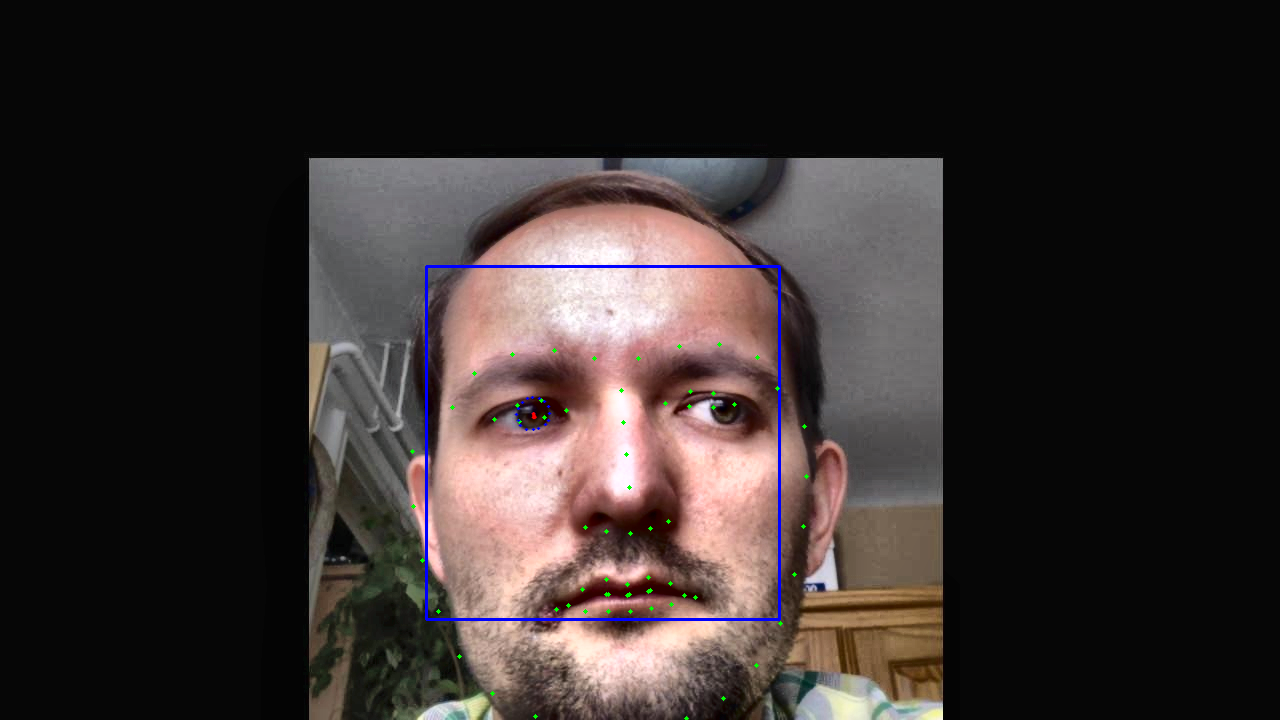

Left eye - Pitch: 163.68°, Yaw: -176.47°
Left eye - Angular Error: 15.62°


In [ ]:
from google.colab import drive
import os
import torch
from typing import List
import numpy as np
import cv2
import dlib
from imutils import face_utils
from models.eyenet import EyeNet
from util.eye_prediction import EyePrediction
from util.eye_sample import EyeSample
import util.gaze
from google.colab.patches import cv2_imshow
import math
from scipy.spatial.transform import Rotation as R
import scipy.io

# Mount Google Drive
drive.mount('/content/drive')

# Change directory to the cloned repository
%cd /content/drive/My Drive/colab_data/gaze-estimation

# Install dependencies
!pip install dlib imutils

torch.backends.cudnn.enabled = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Load the landmark detector
landmarks_detector = dlib.shape_predictor('/content/drive/MyDrive/colab_data/gaze-estimation/shape_predictor_68_face_landmarks (1).dat')

# Verify the path to the MMOD face detector model
mmod_model_path = '/content/drive/MyDrive/colab_data/gaze-estimation/mmod_human_face_detector.dat'
if not os.path.isfile(mmod_model_path):
    raise FileNotFoundError(f"MMOD face detector model not found at {mmod_model_path}")

# Load the Dlib MMOD face detector
face_detector = dlib.cnn_face_detection_model_v1(mmod_model_path)

# Load the EyeNet model
checkpoint = torch.load('/content/drive/MyDrive/colab_data/gaze-estimation/checkpoint.pt', map_location=device)
nstack = checkpoint['nstack']
nfeatures = checkpoint['nfeatures']
nlandmarks = checkpoint['nlandmarks']
eyenet = EyeNet(nstack=nstack, nfeatures=nfeatures, nlandmarks=nlandmarks).to(device)
eyenet.load_state_dict(checkpoint['model_state_dict'])

def save_image(image, step):
    cv2.imwrite(f'/content/drive/MyDrive/colab_data/gaze-estimation/{step}.png', image)
    cv2_imshow(image)

def enhance_image(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return enhanced_img

def augment_image(image):
    # Apply random rotations, flips, and brightness adjustments
    if np.random.rand() > 0.5:
        image = cv2.flip(image, 1)
    angle = np.random.uniform(-15, 15)
    M = cv2.getRotationMatrix2D((image.shape[1] // 2, image.shape[0] // 2), angle, 1)
    image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    brightness = np.random.uniform(0.7, 1.3)
    image = cv2.convertScaleAbs(image, alpha=brightness, beta=0)
    return image

def normalize_image(image):
    return image / 255.0

def process_frame(frame_bgr, eye_preds_cache, visualize):
    if visualize:
        save_image(frame_bgr, 'original_image')

    orig_frame = frame_bgr.copy()
    enhanced_frame = enhance_image(orig_frame)
    augmented_frame = augment_image(enhanced_frame)
    normalized_frame = normalize_image(augmented_frame)

    if visualize:
        save_image(normalized_frame, 'enhanced_image')

    gray_frame = cv2.cvtColor(enhanced_frame, cv2.COLOR_BGR2GRAY)

    # Use Dlib MMOD face detector
    faces = face_detector(gray_frame, 1)

    # Draw rectangles around detected faces
    for face in faces:
        x, y, w, h = (face.rect.left(), face.rect.top(), face.rect.width(), face.rect.height())
        cv2.rectangle(enhanced_frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

    if visualize:
        save_image(enhanced_frame, 'detected_faces')

    if len(faces) == 0:
        return enhanced_frame, eye_preds_cache, []

    next_face = faces[0].rect
    landmarks = detect_landmarks(next_face, gray_frame)

    if visualize:
        for (x, y) in landmarks:
            cv2.circle(enhanced_frame, (x, y), 2, (0, 255, 0), -1)
        save_image(enhanced_frame, 'detected_landmarks')

    gaze_angles = []

    if landmarks is not None:
        eye_samples = segment_eyes(gray_frame, landmarks)
        eye_preds_cache = run_eyenet(eye_samples)

        left_eyes = list(filter(lambda x: x.eye_sample.is_left, eye_preds_cache))

        for ep in left_eyes:
            if ep is not None:
                for (x, y) in ep.landmarks[16:33]:
                    cv2.circle(enhanced_frame, (int(round(x)), int(round(y))), 1, (255, 0, 0), -1, lineType=cv2.LINE_AA)

                gaze = ep.gaze.copy()
                gaze[1] = -gaze[1]

                # Calculate gaze angles
                pitch = math.atan2(-gaze[1], -gaze[0])
                yaw = math.atan2(-gaze[0], -1.0)

                pitch_deg = math.degrees(pitch)
                yaw_deg = math.degrees(yaw)

                gaze_angles.append({
                    'eye': 'left',
                    'pitch': pitch_deg,
                    'yaw': yaw_deg
                })

                util.gaze.draw_gaze(enhanced_frame, ep.landmarks[-2], gaze, length=60.0, thickness=2)

    if visualize:
        save_image(enhanced_frame, 'gaze_estimation')

    return enhanced_frame, eye_preds_cache, gaze_angles

def detect_landmarks(face, frame):
    rectangle = dlib.rectangle(face.left(), face.top(), face.right(), face.bottom())
    face_landmarks = landmarks_detector(frame, rectangle)
    return face_utils.shape_to_np(face_landmarks)

def segment_eyes(frame, landmarks, ow=160, oh=96):
    eyes = []
    for corner1, corner2, is_left in [(36, 39, True)]:
        x1, y1 = landmarks[corner1, :]
        x2, y2 = landmarks[corner2, :]
        eye_width = 1.5 * np.linalg.norm(landmarks[corner1, :] - landmarks[corner2, :])
        if eye_width == 0.0:
            continue
        cx, cy = 0.5 * (x1 + x2), 0.5 * (y1 + y2)
        translate_mat = np.asmatrix(np.eye(3))
        translate_mat[:2, 2] = [[-cx], [-cy]]
        scale = ow / eye_width
        scale_mat = np.asmatrix(np.eye(3))
        scale_mat[0, 0] = scale_mat[1, 1] = scale
        center_mat = np.asmatrix(np.eye(3))
        center_mat[:2, 2] = [[0.5 * ow], [0.5 * oh]]
        transform_mat = center_mat * scale_mat * translate_mat
        transform_inv = np.linalg.inv(transform_mat)

        eye_image = cv2.warpAffine(frame, transform_mat[:2], (ow, oh))
        eye_image = cv2.equalizeHist(eye_image)
        if is_left:
            eye_image = np.fliplr(eye_image)

        eyes.append(EyeSample(orig_img=frame.copy(),
                              img=eye_image,
                              transform_inv=transform_inv,
                              is_left=is_left,
                              estimated_radius=0.5 * eye_width * scale))
    return eyes

def run_eyenet(eyes: List[EyeSample], ow=160, oh=96) -> List[EyePrediction]:
    result = []
    for eye in eyes:
        with torch.no_grad():
            x = torch.tensor([eye.img], dtype=torch.float32).to(device)
            _, landmarks, gaze = eyenet.forward(x)
            landmarks = np.asarray(landmarks.cpu().numpy()[0])
            gaze = np.asarray(gaze.cpu().numpy()[0])
            assert gaze.shape == (2,)
            assert landmarks.shape == (34, 2)
            landmarks = landmarks * np.array([oh / 48, ow / 80])
            temp = np.zeros((34, 3))
            if eye.is_left:
                temp[:, 0] = ow - landmarks[:, 1]
            else:
                temp[:, 0] = landmarks[:, 1]
            temp[:, 1] = landmarks[:, 0]
            temp[:, 2] = 1.0
            landmarks = temp
            assert landmarks.shape == (34, 3)
            landmarks = np.asarray(np.matmul(landmarks, eye.transform_inv.T))[:, :2]
            assert landmarks.shape == (34, 2)
            result.append(EyePrediction(eye_sample=eye, landmarks=landmarks, gaze=gaze))
    return result

def calculate_angular_error(gaze1, gaze2):
    return np.degrees(np.arccos(np.clip(np.dot(gaze1, gaze2) / (np.linalg.norm(gaze1) * np.linalg.norm(gaze2)), -1.0, 1.0)))

# Path to the input image
input_image_path = '/content/drive/MyDrive/colab_data/gaze-estimation/0072.jpg'

# Path to save the output image
output_image_path = '/content/drive/MyDrive/colab_data/gaze-estimation/output_image.jpg'

# Read the image
image = cv2.imread(input_image_path)
if image is None:
    raise FileNotFoundError(f"Input image not found at {input_image_path}")

# Process the image
visualize = True
eye_preds_cache = None
processed_image, eye_preds_cache, gaze_angles = process_frame(image, eye_preds_cache, visualize)

# Save the processed image
cv2.imwrite(output_image_path, processed_image)
cv2_imshow(processed_image)

# Ground truth gaze direction (from the provided annotation)
face_center = np.array([-3.416889, 38.737221, 382.846659])
gaze_target = np.array([105.939939, 14.909899, 53.143175])
ground_truth_gaze = gaze_target - face_center
ground_truth_gaze = ground_truth_gaze / np.linalg.norm(ground_truth_gaze)

# Print gaze angles and calculate angular error
for angle in gaze_angles:
    print(f"{angle['eye'].capitalize()} eye - Pitch: {angle['pitch']:.2f}°, Yaw: {angle['yaw']:.2f}°")

# Calculate angular error for the left eye
for ep in eye_preds_cache:
    if ep.eye_sample.is_left:
        predicted_gaze = np.array([ep.gaze[0], ep.gaze[1], -1.0])  # Assuming z-component is -1.0
        predicted_gaze = predicted_gaze / np.linalg.norm(predicted_gaze)
        angular_error = calculate_angular_error(ground_truth_gaze, predicted_gaze)
        print(f"Left eye - Angular Error: {angular_error:.2f}°")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/colab_data/gaze-estimation
cuda:0
Camera Data Keys: dict_keys(['__header__', '__version__', '__globals__', 'cameraMatrix', 'distCoeffs', 'retval', 'rvecs', 'tvecs'])
Monitor Pose Data Keys: dict_keys(['__header__', '__version__', '__globals__', 'rvects', 'tvecs'])
Screen Size Data Keys: dict_keys(['__header__', '__version__', '__globals__', 'height_mm', 'height_pixel', 'width_mm', 'width_pixel'])


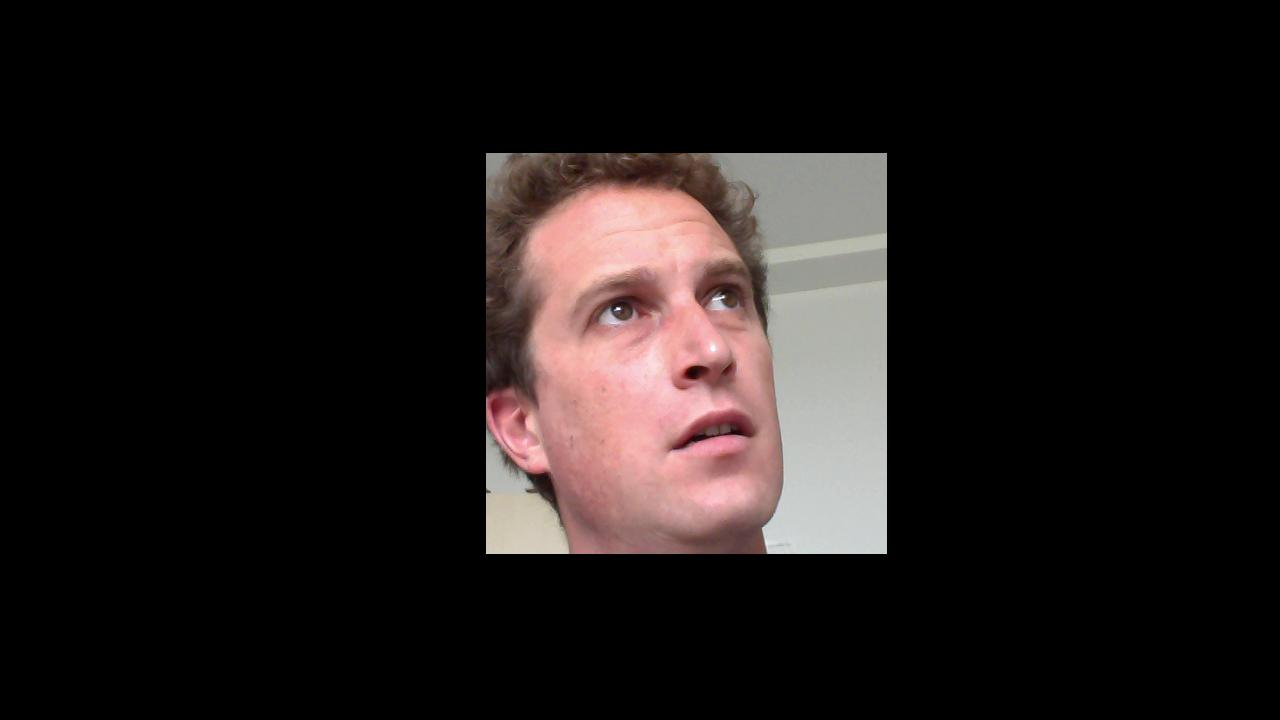

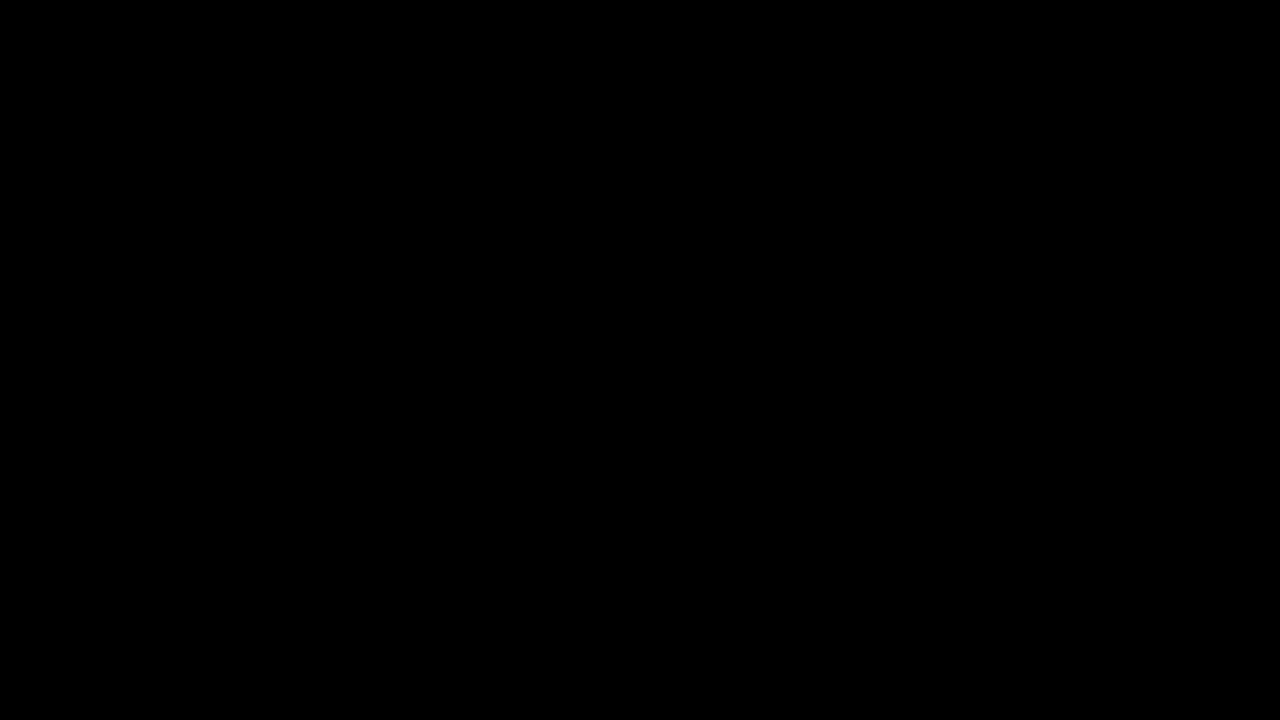

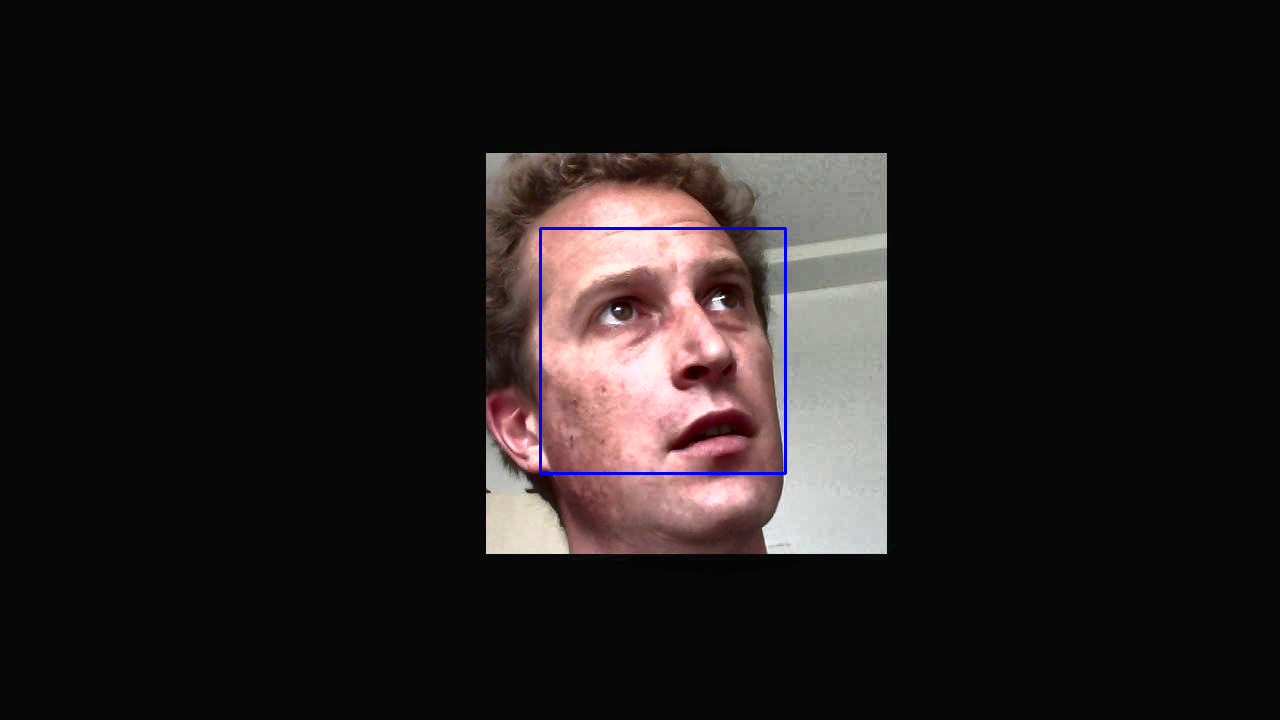

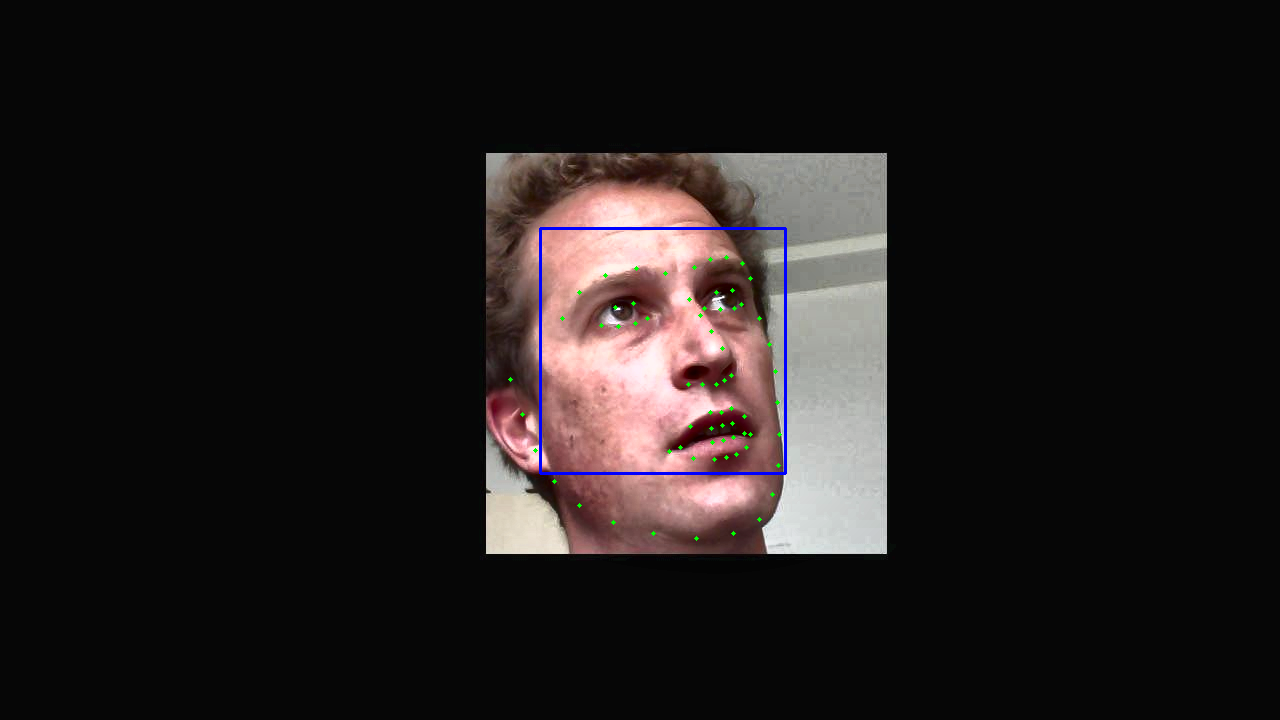

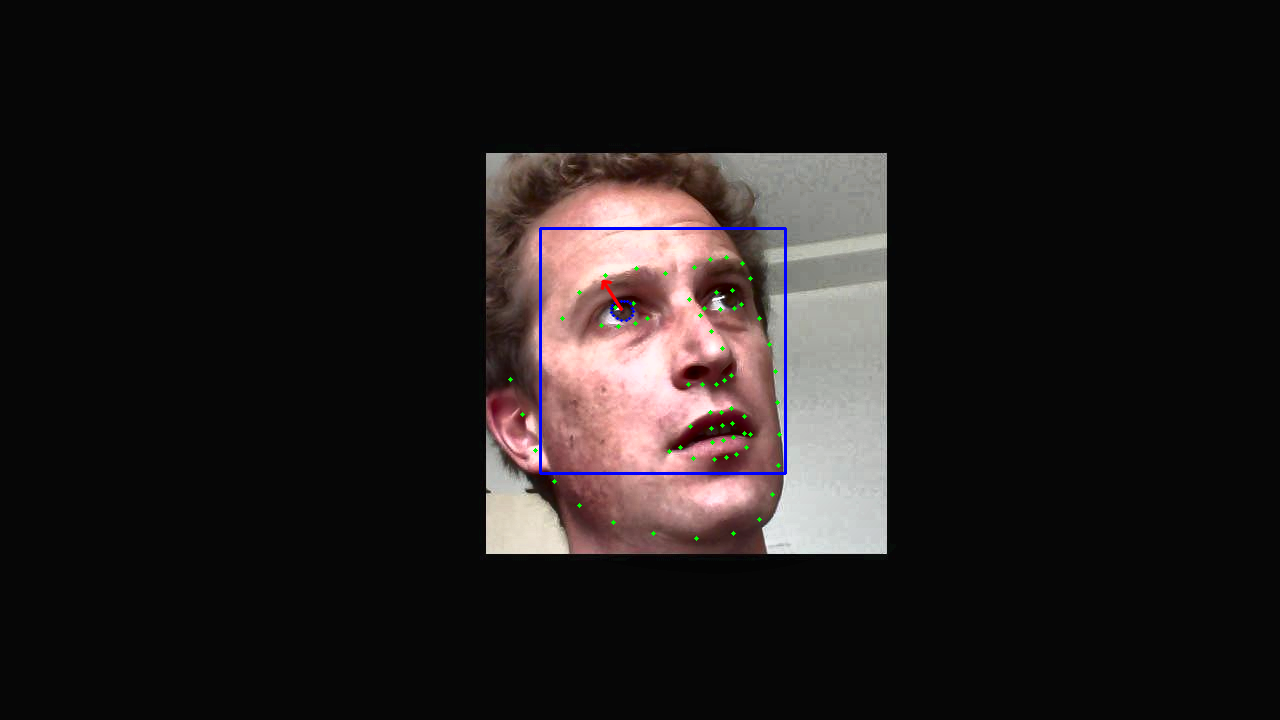

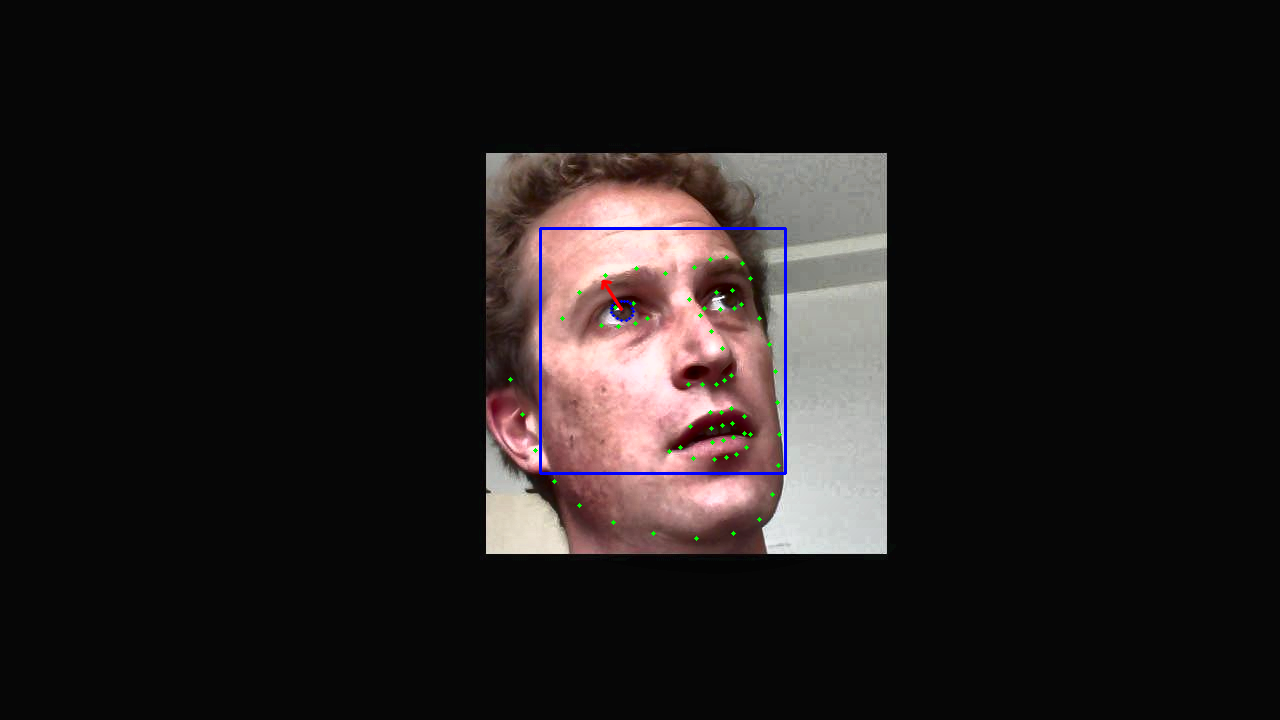

Left eye - Pitch: -31.84°, Yaw: 153.65°
Left eye - Angular Error: 26.54°


In [ ]:
from google.colab import drive
import os
import torch
from typing import List
import numpy as np
import cv2
import dlib
from imutils import face_utils
from models.eyenet import EyeNet
from util.eye_prediction import EyePrediction
from util.eye_sample import EyeSample
import util.gaze
from google.colab.patches import cv2_imshow
import math
from scipy.spatial.transform import Rotation as R
import scipy.io

# Mount Google Drive
drive.mount('/content/drive')

# Change directory to the cloned repository
%cd /content/drive/My Drive/colab_data/gaze-estimation

# Install dependencies
!pip install dlib imutils

torch.backends.cudnn.enabled = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Load the landmark detector
landmarks_detector = dlib.shape_predictor('/content/drive/MyDrive/colab_data/gaze-estimation/shape_predictor_68_face_landmarks (1).dat')

# Verify the path to the MMOD face detector model
mmod_model_path = '/content/drive/MyDrive/colab_data/gaze-estimation/mmod_human_face_detector.dat'
if not os.path.isfile(mmod_model_path):
    raise FileNotFoundError(f"MMOD face detector model not found at {mmod_model_path}")

# Load the Dlib MMOD face detector
face_detector = dlib.cnn_face_detection_model_v1(mmod_model_path)

# Load the EyeNet model
checkpoint = torch.load('/content/drive/MyDrive/colab_data/gaze-estimation/checkpoint.pt', map_location=device)
nstack = checkpoint['nstack']
nfeatures = checkpoint['nfeatures']
nlandmarks = checkpoint['nlandmarks']
eyenet = EyeNet(nstack=nstack, nfeatures=nfeatures, nlandmarks=nlandmarks).to(device)
eyenet.load_state_dict(checkpoint['model_state_dict'])

def save_image(image, step):
    cv2.imwrite(f'/content/drive/MyDrive/colab_data/gaze-estimation/{step}.png', image)
    cv2_imshow(image)

def enhance_image(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return enhanced_img

def augment_image(image):
    # Apply random rotations, flips, and brightness adjustments
    if np.random.rand() > 0.5:
        image = cv2.flip(image, 1)
    angle = np.random.uniform(-15, 15)
    M = cv2.getRotationMatrix2D((image.shape[1] // 2, image.shape[0] // 2), angle, 1)
    image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    brightness = np.random.uniform(0.7, 1.3)
    image = cv2.convertScaleAbs(image, alpha=brightness, beta=0)
    return image

def normalize_image(image):
    return image / 255.0

def process_frame(frame_bgr, eye_preds_cache, visualize):
    if visualize:
        save_image(frame_bgr, 'original_image')

    orig_frame = frame_bgr.copy()
    enhanced_frame = enhance_image(orig_frame)
    augmented_frame = augment_image(enhanced_frame)
    normalized_frame = normalize_image(augmented_frame)

    if visualize:
        save_image(normalized_frame, 'enhanced_image')

    gray_frame = cv2.cvtColor(enhanced_frame, cv2.COLOR_BGR2GRAY)

    # Use Dlib MMOD face detector
    faces = face_detector(gray_frame, 1)

    # Draw rectangles around detected faces
    for face in faces:
        x, y, w, h = (face.rect.left(), face.rect.top(), face.rect.width(), face.rect.height())
        cv2.rectangle(enhanced_frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

    if visualize:
        save_image(enhanced_frame, 'detected_faces')

    if len(faces) == 0:
        return enhanced_frame, eye_preds_cache, []

    next_face = faces[0].rect
    landmarks = detect_landmarks(next_face, gray_frame)

    if visualize:
        for (x, y) in landmarks:
            cv2.circle(enhanced_frame, (x, y), 2, (0, 255, 0), -1)
        save_image(enhanced_frame, 'detected_landmarks')

    gaze_angles = []

    if landmarks is not None:
        eye_samples = segment_eyes(gray_frame, landmarks)
        eye_preds_cache = run_eyenet(eye_samples)

        left_eyes = list(filter(lambda x: x.eye_sample.is_left, eye_preds_cache))

        for ep in left_eyes:
            if ep is not None:
                for (x, y) in ep.landmarks[16:33]:
                    cv2.circle(enhanced_frame, (int(round(x)), int(round(y))), 1, (255, 0, 0), -1, lineType=cv2.LINE_AA)

                gaze = ep.gaze.copy()
                gaze[1] = -gaze[1]

                # Calculate gaze angles
                pitch = math.atan2(-gaze[1], -gaze[0])
                yaw = math.atan2(-gaze[0], -1.0)

                pitch_deg = math.degrees(pitch)
                yaw_deg = math.degrees(yaw)

                gaze_angles.append({
                    'eye': 'left',
                    'pitch': pitch_deg,
                    'yaw': yaw_deg
                })

                util.gaze.draw_gaze(enhanced_frame, ep.landmarks[-2], gaze, length=60.0, thickness=2)

    if visualize:
        save_image(enhanced_frame, 'gaze_estimation')

    return enhanced_frame, eye_preds_cache, gaze_angles

def detect_landmarks(face, frame):
    rectangle = dlib.rectangle(face.left(), face.top(), face.right(), face.bottom())
    face_landmarks = landmarks_detector(frame, rectangle)
    return face_utils.shape_to_np(face_landmarks)

def segment_eyes(frame, landmarks, ow=160, oh=96):
    eyes = []
    for corner1, corner2, is_left in [(36, 39, True)]:
        x1, y1 = landmarks[corner1, :]
        x2, y2 = landmarks[corner2, :]
        eye_width = 1.5 * np.linalg.norm(landmarks[corner1, :] - landmarks[corner2, :])
        if eye_width == 0.0:
            continue
        cx, cy = 0.5 * (x1 + x2), 0.5 * (y1 + y2)
        translate_mat = np.asmatrix(np.eye(3))
        translate_mat[:2, 2] = [[-cx], [-cy]]
        scale = ow / eye_width
        scale_mat = np.asmatrix(np.eye(3))
        scale_mat[0, 0] = scale_mat[1, 1] = scale
        center_mat = np.asmatrix(np.eye(3))
        center_mat[:2, 2] = [[0.5 * ow], [0.5 * oh]]
        transform_mat = center_mat * scale_mat * translate_mat
        transform_inv = np.linalg.inv(transform_mat)

        eye_image = cv2.warpAffine(frame, transform_mat[:2], (ow, oh))
        eye_image = cv2.equalizeHist(eye_image)
        if is_left:
            eye_image = np.fliplr(eye_image)

        eyes.append(EyeSample(orig_img=frame.copy(),
                              img=eye_image,
                              transform_inv=transform_inv,
                              is_left=is_left,
                              estimated_radius=0.5 * eye_width * scale))
    return eyes

def run_eyenet(eyes: List[EyeSample], ow=160, oh=96) -> List[EyePrediction]:
    result = []
    for eye in eyes:
        with torch.no_grad():
            x = torch.tensor([eye.img], dtype=torch.float32).to(device)
            _, landmarks, gaze = eyenet.forward(x)
            landmarks = np.asarray(landmarks.cpu().numpy()[0])
            gaze = np.asarray(gaze.cpu().numpy()[0])
            assert gaze.shape == (2,)
            assert landmarks.shape == (34, 2)
            landmarks = landmarks * np.array([oh / 48, ow / 80])
            temp = np.zeros((34, 3))
            if eye.is_left:
                temp[:, 0] = ow - landmarks[:, 1]
            else:
                temp[:, 0] = landmarks[:, 1]
            temp[:, 1] = landmarks[:, 0]
            temp[:, 2] = 1.0
            landmarks = temp
            assert landmarks.shape == (34, 3)
            landmarks = np.asarray(np.matmul(landmarks, eye.transform_inv.T))[:, :2]
            assert landmarks.shape == (34, 2)
            result.append(EyePrediction(eye_sample=eye, landmarks=landmarks, gaze=gaze))
    return result

def calculate_angular_error(gaze1, gaze2):
    return np.degrees(np.arccos(np.clip(np.dot(gaze1, gaze2) / (np.linalg.norm(gaze1) * np.linalg.norm(gaze2)), -1.0, 1.0)))

# Function to read calibration files and use values in main code
def read_calibration_files(camera_path, monitor_pose_path, screen_size_path):
    camera_data = scipy.io.loadmat(camera_path)
    monitor_pose_data = scipy.io.loadmat(monitor_pose_path)
    screen_size_data = scipy.io.loadmat(screen_size_path)

    print("Camera Data Keys:", camera_data.keys())
    print("Monitor Pose Data Keys:", monitor_pose_data.keys())
    print("Screen Size Data Keys:", screen_size_data.keys())

    camera_matrix = camera_data['cameraMatrix']
    dist_coeffs = camera_data['distCoeffs']
    monitor_rvecs = monitor_pose_data['rvects']  # Corrected key
    monitor_tvecs = monitor_pose_data['tvecs']
    screen_height_pixel = screen_size_data['height_pixel']
    screen_width_pixel = screen_size_data['width_pixel']
    screen_height_mm = screen_size_data['height_mm']
    screen_width_mm = screen_size_data['width_mm']

    return {
        "camera_matrix": camera_matrix,
        "dist_coeffs": dist_coeffs,
        "monitor_rvecs": monitor_rvecs,
        "monitor_tvecs": monitor_tvecs,
        "screen_height_pixel": screen_height_pixel,
        "screen_width_pixel": screen_width_pixel,
        "screen_height_mm": screen_height_mm,
        "screen_width_mm": screen_width_mm
    }

# Example paths to the calibration files
camera_path = '/content/drive/MyDrive/colab_data/gaze-estimation/Camera.mat'
monitor_pose_path = '/content/drive/MyDrive/colab_data/gaze-estimation/monitorPose.mat'
screen_size_path = '/content/drive/MyDrive/colab_data/gaze-estimation/screenSize.mat'

# Read the calibration data
calibration_data = read_calibration_files(camera_path, monitor_pose_path, screen_size_path)

# Path to the input image
input_image_path = '/content/drive/MyDrive/colab_data/gaze-estimation/0010.jpg'

# Path to save the output image
output_image_path = '/content/drive/MyDrive/colab_data/gaze-estimation/output_image.jpg'

# Read the image
image = cv2.imread(input_image_path)
if image is None:
    raise FileNotFoundError(f"Input image not found at {input_image_path}")

# Process the image
visualize = True
eye_preds_cache = None
processed_image, eye_preds_cache, gaze_angles = process_frame(image, eye_preds_cache, visualize)

# Save the processed image
cv2.imwrite(output_image_path, processed_image)
cv2_imshow(processed_image)

# Ground truth gaze direction (from the provided annotation)
face_center = np.array([19.160914, 1.711814, 511.777387])
gaze_target = np.array([-80.928561, 60.278903, 8.590967])
ground_truth_gaze = gaze_target - face_center
ground_truth_gaze = ground_truth_gaze / np.linalg.norm(ground_truth_gaze)

# Print gaze angles and calculate angular error
for angle in gaze_angles:
    print(f"{angle['eye'].capitalize()} eye - Pitch: {angle['pitch']:.2f}°, Yaw: {angle['yaw']:.2f}°")

# Calculate angular error for the left eye
for ep in eye_preds_cache:
    if ep.eye_sample.is_left:
        predicted_gaze = np.array([ep.gaze[0], ep.gaze[1], -1.0])  # Assuming z-component is -1.0
        predicted_gaze = predicted_gaze / np.linalg.norm(predicted_gaze)
        angular_error = calculate_angular_error(ground_truth_gaze, predicted_gaze)
        print(f"Left eye - Angular Error: {angular_error:.2f}°")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/colab_data/gaze-estimation


Actual Pitch: 14.93°, Actual Yaw: -170.11°
Predicted Pitch: 19.52°, Predicted Yaw: -170.21°
Angular Error: 6.75°
Actual Gaze Vector: [ 0.17428587 -0.25771135]
Predicted Gaze Vector: [ 0.17261527 -0.33409452]


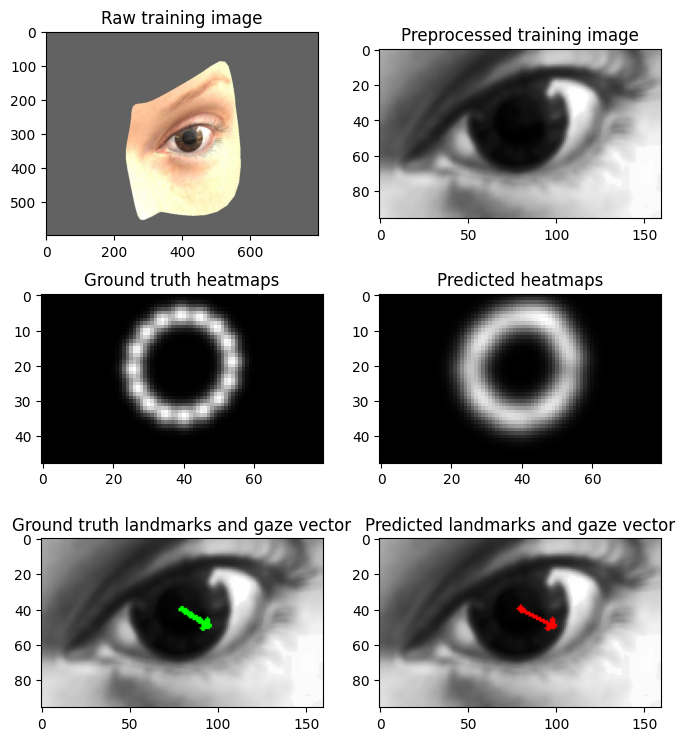

In [6]:
from google.colab import drive
import os
import torch
import numpy as np
import cv2
from matplotlib import pyplot as plt
from datasets.unity_eyes import UnityEyesDataset
from models.eyenet import EyeNet
from util.preprocess import gaussian_2d
from util.gaze import draw_gaze

# Mount Google Drive
drive.mount('/content/drive')

# Change directory to the cloned repository
%cd /content/drive/My Drive/colab_data/gaze-estimation

# Install dependencies
!pip install dlib imutils

# Device configuration
device = torch.device('cpu')

# Initialize the dataset
dataset = UnityEyesDataset()

# Load the model checkpoint
checkpoint_path = 'checkpoint.pt'
checkpoint = torch.load(checkpoint_path, map_location=device)
nstack = checkpoint['nstack']
nfeatures = checkpoint['nfeatures']
nlandmarks = checkpoint['nlandmarks']

# Initialize the EyeNet model
eyenet = EyeNet(nstack=nstack, nfeatures=nfeatures, nlandmarks=nlandmarks).to(device)
eyenet.load_state_dict(checkpoint['model_state_dict'])

# Process a sample from the dataset
with torch.no_grad():
    sample = dataset[2]
    x = torch.tensor([sample['img']]).float().to(device)
    heatmaps = sample['heatmaps']
    heatmaps_pred, landmarks_pred, gaze_pred = eyenet.forward(x)

    landmarks_pred = landmarks_pred.cpu().numpy()[0, :]
    gaze_pred = gaze_pred.cpu().numpy()[0, :]

    result = [gaussian_2d(w=80, h=48, cx=c[1], cy=c[0], sigma=3) for c in landmarks_pred]

    plt.figure(figsize=(8, 9))

    iris_center = sample['landmarks'][-2][::-1]
    iris_center *= 2
    img = sample['img']

    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    img_gaze_pred = img.copy()
    for (y, x) in landmarks_pred[-2:-1]:
        cv2.circle(img_gaze_pred, (int(x*2), int(y*2)), 2, (255, 0, 0), -1)
    draw_gaze(img_gaze_pred, iris_center, gaze_pred, length=60, color=(255, 0, 0))

    img_gaze = img.copy()
    for (x, y) in sample['landmarks'][-2:-1]:
        cv2.circle(img_gaze, (int(x*2), int(y*2)), 2, (0, 255, 0), -1)
    draw_gaze(img_gaze, iris_center, sample['gaze'], length=60, color=(0, 255, 0))

    # Calculate pitch and yaw
    def gaze_to_pitch_yaw(gaze):
        pitch = np.arcsin(-gaze[1])
        yaw = np.arctan2(-gaze[0], -1.0)  # Assuming gaze[2] is always -1
        return np.degrees(pitch), np.degrees(yaw)

    # Calculate angular error
    def angular_error(gaze1, gaze2):
        return np.degrees(np.arccos(np.clip(np.dot(gaze1, gaze2) / (np.linalg.norm(gaze1) * np.linalg.norm(gaze2)), -1.0, 1.0)))

    actual_pitch, actual_yaw = gaze_to_pitch_yaw(sample['gaze'])
    pred_pitch, pred_yaw = gaze_to_pitch_yaw(gaze_pred)
    error = angular_error(sample['gaze'], gaze_pred)

    print(f"Actual Pitch: {actual_pitch:.2f}°, Actual Yaw: {actual_yaw:.2f}°")
    print(f"Predicted Pitch: {pred_pitch:.2f}°, Predicted Yaw: {pred_yaw:.2f}°")
    print(f"Angular Error: {error:.2f}°")
    print(f"Actual Gaze Vector: {sample['gaze']}")
    print(f"Predicted Gaze Vector: {gaze_pred}")

    plt.subplot(321)
    plt.imshow(cv2.cvtColor(sample['full_img'], cv2.COLOR_BGR2RGB))
    plt.title('Raw training image')

    plt.subplot(322)
    plt.imshow(img, cmap='gray')
    plt.title('Preprocessed training image')

    plt.subplot(323)
    plt.imshow(np.mean(heatmaps[16:32], axis=0), cmap='gray')
    plt.title('Ground truth heatmaps')

    plt.subplot(324)
    plt.imshow(np.mean(result[16:32], axis=0), cmap='gray')
    plt.title('Predicted heatmaps')

    plt.subplot(325)
    plt.imshow(img_gaze, cmap='gray')
    plt.title('Ground truth landmarks and gaze vector')

    plt.subplot(326)
    plt.imshow(img_gaze_pred, cmap='gray')
    plt.title('Predicted landmarks and gaze vector')
    plt.show()